# SLAMseq

## Installing slamdunk (only do once)

In [1]:
# install slamdunk
#! pip3 install git+https://github.com/jkobject/slamdunk.git --upgrade

In [2]:
# clone and install genepy
# pip install -e genepy

In [3]:
# please also install cutadapt, fastqc, and trimgalore
#! conda install -c bioconda cutadapt
#! conda install -c bioconda fastqc
#! conda install -c bioconda trim-galore

In [4]:
from __future__ import print_function
import os.path
import pandas as pd
import sys
sys.path.insert(0, '../../')
import seaborn as sns
import numpy as np
from natsort import os_sorted

from genepy.utils import helper as h
from genepy.utils import plot as genepyPlot
from genepy.rna import pyDESeq2
import genepy.rna as rna

In [6]:
from bokeh.plotting import *
from bokeh.models import HoverTool
from bokeh.io import output_notebook

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
#from umap import UMAP

output_notebook()
%load_ext autoreload
%matplotlib inline
%autoreload 2
%load_ext rpy2.ipython

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [7]:
def createDir(directory):
    if not os.path.exists(directory):
        print("Creating output directory: " + directory)
        os.makedirs(directory)

# MV411 inhibitors

SLAMseq of MV411 with MYC, CDK9, THC1 inhibitors
<br>1h incubation with respective agent + 1h 4sU with 0.5$\mu$M VHL (with ERCC spike-in control mix #1 used)
<br>MS2: 50$\mu$M
<br>JQ1: 1$\mu$M
<br>MYCi361: 10$\mu$M
<br>THZ1: 10$\mu$M
<br>DMSO brought up to 0.25% for all samples
<br>__Processed without alt loci__

In [8]:
project = "inhibitors_v2"

In [9]:
location = "../data/slamseq_"+project+"/" # new data location

## download the data

In [10]:
location = "../data/slamseq_"+project+"/" # new data location
loc = "220610_MP10091_fastq" # transfer AML folder

In [11]:
! mkdir ../$location
! mkdir ../results/slamseq_$project
! mkdir $location && mkdir $location/qc # make data dir in AMLproject
! mkdir ../$location/fastqs/ # make dir in /home/monika/data/project/fastqs

In [13]:
! gsutil ls gs://transfer-amlproject/$loc/*.fastq.gz

gs://transfer-amlproject/220610_MP10091_fastq/20220610_10_MV411_JQ1_B_MP10091_S10_R1_001.fastq.gz
gs://transfer-amlproject/220610_MP10091_fastq/20220610_10_MV411_JQ1_B_MP10091_S10_R2_001.fastq.gz
gs://transfer-amlproject/220610_MP10091_fastq/20220610_11_MV411_JQ1_C_MP10091_S11_R1_001.fastq.gz
gs://transfer-amlproject/220610_MP10091_fastq/20220610_11_MV411_JQ1_C_MP10091_S11_R2_001.fastq.gz
gs://transfer-amlproject/220610_MP10091_fastq/20220610_12_MV411_JQ1_D_MP10091_S12_R1_001.fastq.gz
gs://transfer-amlproject/220610_MP10091_fastq/20220610_12_MV411_JQ1_D_MP10091_S12_R2_001.fastq.gz
gs://transfer-amlproject/220610_MP10091_fastq/20220610_13_MV411_MYCi361_A_MP10091_S13_R1_001.fastq.gz
gs://transfer-amlproject/220610_MP10091_fastq/20220610_13_MV411_MYCi361_A_MP10091_S13_R2_001.fastq.gz
gs://transfer-amlproject/220610_MP10091_fastq/20220610_14_MV411_MYCi361_B_MP10091_S14_R1_001.fastq.gz
gs://transfer-amlproject/220610_MP10091_fastq/20220610_14_MV411_MYCi361_B_MP10091_S14_R2_001.fastq.gz
gs:/

In [14]:
# transfer qc files
! gsutil -m cp gs://transfer-amlproject/$loc/multiqc_report.html $location/qc/
! gsutil -m cp -r gs://transfer-amlproject/$loc/Reports/ $location/qc/
! gsutil -m cp -r gs://transfer-amlproject/$loc/multiqc_data/ $location/qc/

Copying gs://transfer-amlproject/220610_MP10091_fastq/multiqc_report.html...
/ [1/1 files][  1.7 MiB/  1.7 MiB] 100% Done                                    
Operation completed over 1 objects/1.7 MiB.                                      
Copying gs://transfer-amlproject/220610_MP10091_fastq/Reports/20220610_10_MV411_JQ1_B_MP10091_S10_R1_001_fastqc.html...
Copying gs://transfer-amlproject/220610_MP10091_fastq/Reports/20220610_10_MV411_JQ1_B_MP10091_S10_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/220610_MP10091_fastq/Reports/20220610_10_MV411_JQ1_B_MP10091_S10_R2_001_fastqc.html...
Copying gs://transfer-amlproject/220610_MP10091_fastq/Reports/20220610_10_MV411_JQ1_B_MP10091_S10_R2_001_fastqc.zip...
Copying gs://transfer-amlproject/220610_MP10091_fastq/Reports/20220610_11_MV411_JQ1_C_MP10091_S11_R1_001_fastqc.html...
Copying gs://transfer-amlproject/220610_MP10091_fastq/Reports/20220610_11_MV411_JQ1_C_MP10091_S11_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/220610_MP1

Copying gs://transfer-amlproject/220610_MP10091_fastq/Reports/20220610_26_MV411_JQ1THZ1_B_MP10091_S26_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/220610_MP10091_fastq/Reports/20220610_26_MV411_JQ1THZ1_B_MP10091_S26_R2_001_fastqc.html...
Copying gs://transfer-amlproject/220610_MP10091_fastq/Reports/20220610_26_MV411_JQ1THZ1_B_MP10091_S26_R2_001_fastqc.zip...
Copying gs://transfer-amlproject/220610_MP10091_fastq/Reports/20220610_27_MV411_JQ1THZ1_C_MP10091_S27_R1_001_fastqc.html...
Copying gs://transfer-amlproject/220610_MP10091_fastq/Reports/20220610_27_MV411_JQ1THZ1_C_MP10091_S27_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/220610_MP10091_fastq/Reports/20220610_27_MV411_JQ1THZ1_C_MP10091_S27_R2_001_fastqc.html...
Copying gs://transfer-amlproject/220610_MP10091_fastq/Reports/20220610_28_MV411_JQ1THZ1_D_MP10091_S28_R1_001_fastqc.html...
Copying gs://transfer-amlproject/220610_MP10091_fastq/Reports/20220610_27_MV411_JQ1THZ1_C_MP10091_S27_R2_001_fastqc.zip...
Copying gs:/

In [15]:
! cp $location/qc/multiqc_report.html ../results/slamseq_$project

In [16]:
fastqs = ! gsutil ls gs://transfer-amlproject/$loc/*.gz

add sample names to AML sample tracker google sheet (RNA_tracker_JK)

In [17]:
print(len(fastqs))
[f.split("_R")[0] for f in fastqs[::2]]

56


['gs://transfer-amlproject/220610_MP10091_fastq/20220610_10_MV411_JQ1_B_MP10091_S10',
 'gs://transfer-amlproject/220610_MP10091_fastq/20220610_11_MV411_JQ1_C_MP10091_S11',
 'gs://transfer-amlproject/220610_MP10091_fastq/20220610_12_MV411_JQ1_D_MP10091_S12',
 'gs://transfer-amlproject/220610_MP10091_fastq/20220610_13_MV411_MYCi361_A_MP10091_S13',
 'gs://transfer-amlproject/220610_MP10091_fastq/20220610_14_MV411_MYCi361_B_MP10091_S14',
 'gs://transfer-amlproject/220610_MP10091_fastq/20220610_15_MV411_MYCi361_C_MP10091_S15',
 'gs://transfer-amlproject/220610_MP10091_fastq/20220610_16_MV411_MYCi361_D_MP10091_S16',
 'gs://transfer-amlproject/220610_MP10091_fastq/20220610_17_MV411_THZ1_A_MP10091_S17',
 'gs://transfer-amlproject/220610_MP10091_fastq/20220610_18_MV411_THZ1_B_MP10091_S18',
 'gs://transfer-amlproject/220610_MP10091_fastq/20220610_19_MV411_THZ1_C_MP10091_S19',
 'gs://transfer-amlproject/220610_MP10091_fastq/20220610_1_MV411_DMSO_A_MP10091_S1',
 'gs://transfer-amlproject/220610_MP

In [18]:
fastqs = [fastq.split("/")[-1] for fastq in os_sorted(fastqs)]
print(len(fastqs))
# add sample names to AML sample tracker google sheet
for val1, val2 in h.grouped(fastqs, 2):
    print(val1.split("_R")[0])

56
20220610_1_MV411_DMSO_A_MP10091_S1
20220610_2_MV411_DMSO_B_MP10091_S2
20220610_3_MV411_DMSO_C_MP10091_S3
20220610_4_MV411_DMSO_D_MP10091_S4
20220610_5_MV411_MS2_A_MP10091_S5
20220610_6_MV411_MS2_B_MP10091_S6
20220610_7_MV411_MS2_C_MP10091_S7
20220610_8_MV411_MS2_D_MP10091_S8
20220610_9_MV411_JQ1_A_MP10091_S9
20220610_10_MV411_JQ1_B_MP10091_S10
20220610_11_MV411_JQ1_C_MP10091_S11
20220610_12_MV411_JQ1_D_MP10091_S12
20220610_13_MV411_MYCi361_A_MP10091_S13
20220610_14_MV411_MYCi361_B_MP10091_S14
20220610_15_MV411_MYCi361_C_MP10091_S15
20220610_16_MV411_MYCi361_D_MP10091_S16
20220610_17_MV411_THZ1_A_MP10091_S17
20220610_18_MV411_THZ1_B_MP10091_S18
20220610_19_MV411_THZ1_C_MP10091_S19
20220610_20_MV411_THZ1_D_MP10091_S20
20220610_21_MV411_JQ1MS2_A_MP10091_S21
20220610_22_MV411_JQ1MS2_B_MP10091_S22
20220610_23_MV411_JQ1MS2_C_MP10091_S23
20220610_24_MV411_JQ1MS2_D_MP10091_S24
20220610_25_MV411_JQ1THZ1_A_MP10091_S25
20220610_26_MV411_JQ1THZ1_B_MP10091_S26
20220610_27_MV411_JQ1THZ1_C_MP10091

In [19]:
# transfer fastqs
! gsutil -m cp gs://transfer-amlproject/$loc/*.fastq.gz ../$location/fastqs/

Copying gs://transfer-amlproject/220610_MP10091_fastq/20220610_10_MV411_JQ1_B_MP10091_S10_R1_001.fastq.gz...
Copying gs://transfer-amlproject/220610_MP10091_fastq/20220610_10_MV411_JQ1_B_MP10091_S10_R2_001.fastq.gz...
Copying gs://transfer-amlproject/220610_MP10091_fastq/20220610_11_MV411_JQ1_C_MP10091_S11_R1_001.fastq.gz...
Copying gs://transfer-amlproject/220610_MP10091_fastq/20220610_12_MV411_JQ1_D_MP10091_S12_R1_001.fastq.gz...
Copying gs://transfer-amlproject/220610_MP10091_fastq/20220610_11_MV411_JQ1_C_MP10091_S11_R2_001.fastq.gz...
Copying gs://transfer-amlproject/220610_MP10091_fastq/20220610_12_MV411_JQ1_D_MP10091_S12_R2_001.fastq.gz...
Copying gs://transfer-amlproject/220610_MP10091_fastq/20220610_13_MV411_MYCi361_A_MP10091_S13_R1_001.fastq.gz...
Copying gs://transfer-amlproject/220610_MP10091_fastq/20220610_13_MV411_MYCi361_A_MP10091_S13_R2_001.fastq.gz...
Copying gs://transfer-amlproject/220610_MP10091_fastq/20220610_14_MV411_MYCi361_B_MP10091_S14_R1_001.fastq.gz...
Copying

## rename local fastqs

In [20]:
fastq_folder = "../"+location+"fastqs"
print(fastq_folder)
fastqs = ! ls $fastq_folder
fastqs = os_sorted(fastqs)
fastqs

../../data/slamseq_inhibitors_v2/fastqs


['20220610_1_MV411_DMSO_A_MP10091_S1_R1_001.fastq.gz',
 '20220610_1_MV411_DMSO_A_MP10091_S1_R2_001.fastq.gz',
 '20220610_2_MV411_DMSO_B_MP10091_S2_R1_001.fastq.gz',
 '20220610_2_MV411_DMSO_B_MP10091_S2_R2_001.fastq.gz',
 '20220610_3_MV411_DMSO_C_MP10091_S3_R1_001.fastq.gz',
 '20220610_3_MV411_DMSO_C_MP10091_S3_R2_001.fastq.gz',
 '20220610_4_MV411_DMSO_D_MP10091_S4_R1_001.fastq.gz',
 '20220610_4_MV411_DMSO_D_MP10091_S4_R2_001.fastq.gz',
 '20220610_5_MV411_MS2_A_MP10091_S5_R1_001.fastq.gz',
 '20220610_5_MV411_MS2_A_MP10091_S5_R2_001.fastq.gz',
 '20220610_6_MV411_MS2_B_MP10091_S6_R1_001.fastq.gz',
 '20220610_6_MV411_MS2_B_MP10091_S6_R2_001.fastq.gz',
 '20220610_7_MV411_MS2_C_MP10091_S7_R1_001.fastq.gz',
 '20220610_7_MV411_MS2_C_MP10091_S7_R2_001.fastq.gz',
 '20220610_8_MV411_MS2_D_MP10091_S8_R1_001.fastq.gz',
 '20220610_8_MV411_MS2_D_MP10091_S8_R2_001.fastq.gz',
 '20220610_9_MV411_JQ1_A_MP10091_S9_R1_001.fastq.gz',
 '20220610_9_MV411_JQ1_A_MP10091_S9_R2_001.fastq.gz',
 '20220610_10_MV411_

In [21]:
from gsheets import Sheets
sheets = Sheets.from_files('~/.client_secret_web.json', '~/.storage.json')
url = "https://docs.google.com/spreadsheets/d/1yFLjYB1McU530JnLgL0QIMAKIkVl3kl0_LCHje2gk8U/edit?ts=5fab1071#gid=738732237"
gsheet = sheets.get(url).sheets[12].to_frame()

In [22]:
# get new sample names from AML sample tracker - RNA_tracker_JK
idx = gsheet.index[gsheet['batch'] == project] # get first row with project number
sample_info = gsheet.loc[idx[0]:, ["prev_name", "name"]]
sample_info = sample_info.iloc[:int(len(fastqs)/2),]
print(sample_info.shape)

(28, 2)


In [23]:
# make dict with names
rename = dict(zip(sample_info.prev_name, sample_info.name))

# rename fastqs locally
for val in fastqs:
    rep  = val
    for old, new in rename.items():
        rep = rep.replace(old, new)
    if rep != val:
        ! mv $fastq_folder/$val $fastq_folder/$rep

# Processing

In [24]:
project

'inhibitors_v2'

In [25]:
fastq_folder = "../"+location+"fastqs"
print(fastq_folder)
fastqs = ! ls $fastq_folder/*fastq.gz
fastqs[::2]

../../data/slamseq_inhibitors_v2/fastqs


['../../data/slamseq_inhibitors_v2/fastqs/mr590-MV411-DMSO_1h-r1_R1_001.fastq.gz',
 '../../data/slamseq_inhibitors_v2/fastqs/mr591-MV411-DMSO_1h-r2_R1_001.fastq.gz',
 '../../data/slamseq_inhibitors_v2/fastqs/mr592-MV411-DMSO_1h-r3_R1_001.fastq.gz',
 '../../data/slamseq_inhibitors_v2/fastqs/mr593-MV411-DMSO_1h-r4_R1_001.fastq.gz',
 '../../data/slamseq_inhibitors_v2/fastqs/mr594-MV411-MS2_1h-r1_R1_001.fastq.gz',
 '../../data/slamseq_inhibitors_v2/fastqs/mr595-MV411-MS2_1h-r2_R1_001.fastq.gz',
 '../../data/slamseq_inhibitors_v2/fastqs/mr596-MV411-MS2_1h-r3_R1_001.fastq.gz',
 '../../data/slamseq_inhibitors_v2/fastqs/mr597-MV411-MS2_1h-r4_R1_001.fastq.gz',
 '../../data/slamseq_inhibitors_v2/fastqs/mr598-MV411-JQ1_1h-r1_R1_001.fastq.gz',
 '../../data/slamseq_inhibitors_v2/fastqs/mr599-MV411-JQ1_1h-r2_R1_001.fastq.gz',
 '../../data/slamseq_inhibitors_v2/fastqs/mr600-MV411-JQ1_1h-r3_R1_001.fastq.gz',
 '../../data/slamseq_inhibitors_v2/fastqs/mr601-MV411-JQ1_1h-r4_R1_001.fastq.gz',
 '../../data

## trim_galore

In [31]:
for val1, val2 in h.grouped(fastqs[16:], 2):
    print(os.path.basename(val1))

mr598-MV411-JQ1_1h-r1_R1_001.fastq.gz
mr599-MV411-JQ1_1h-r2_R1_001.fastq.gz
mr600-MV411-JQ1_1h-r3_R1_001.fastq.gz
mr601-MV411-JQ1_1h-r4_R1_001.fastq.gz
mr602-MV411-MYCi361_1h-r1_R1_001.fastq.gz
mr603-MV411-MYCi361_1h-r2_R1_001.fastq.gz
mr604-MV411-MYCi361_1h-r3_R1_001.fastq.gz
mr605-MV411-MYCi361_1h-r4_R1_001.fastq.gz
mr606-MV411-THZ1_1h-r1_R1_001.fastq.gz
mr607-MV411-THZ1_1h-r2_R1_001.fastq.gz
mr608-MV411-THZ1_1h-r3_R1_001.fastq.gz
mr609-MV411-THZ1_1h-r4_R1_001.fastq.gz
mr610-MV411-JQ1_MS2_1h-r1_R1_001.fastq.gz
mr611-MV411-JQ1_MS2_1h-r2_R1_001.fastq.gz
mr612-MV411-JQ1_MS2_1h-r3_R1_001.fastq.gz
mr613-MV411-JQ1_MS2_1h-r4_R1_001.fastq.gz
mr614-MV411-JQ1_THZ1_1h-r1_R1_001.fastq.gz
mr615-MV411-JQ1_THZ1_1h-r2_R1_001.fastq.gz
mr616-MV411-JQ1_THZ1_1h-r3_R1_001.fastq.gz
mr617-MV411-JQ1_THZ1_1h-r4_R1_001.fastq.gz


In [ ]:
%%time
h.parrun(['trim_galore --paired --cores 8 --retain_unpaired -stringency 3\
 --illumina '+val1+' '+val2+' -o '+fastq_folder for val1, val2 in h.grouped(fastqs[16:], 2)], 2)

## slamdunk

install slamdunk & dependencies if needed (see above)

In [33]:
# install slamdunk
#! pip3 install git+https://github.com/jkobject/slamdunk.git --upgrade

In [34]:
# please also install cutadapt, fastqc, and trimgalore
#! conda install -c bioconda cutadapt
#! conda install -c bioconda fastqc
#! conda install -c bioconda trim-galore

download reference genome files

In [35]:
# google storage bucket with reference files
#! gsutil ls gs://ccle_default_params

# copy reference genome files
#! gsutil -m cp gs://ccle_default_params/Homo_sapiens_assembly38* ../../ref/

# copy reference genome files
#! cp ../data/Muhar_Slamseq/{ERCC92.fa,ERCC92.gtf,GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed} ../../ref

PySam warning can be ignored.
<br>[GitHub issue: [E::idx_find_and_load] Could not retrieve index file" when AlignmentFile](https://github.com/pysam-developers/pysam/issues/939)

In [36]:
# using an ERCC ref genome (you can just append ERCC fasta to the hg38 fasta)
refgenome_noAlt="../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta"

In [37]:
# gene intervals bed (use for all projects)
gene_intervals = "../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed"

res = slamdunk all w/ (-fb, -m, -n 1, -rl 152, -r Homo_sapiens_assembly38_ERCC92_noAlt.fasta)

Read length note!
<br>Difference between min and max read length is > 100bp
<br>Average read length 127 (min: 8, max: 152)

In [38]:
fastq_folder = "../../data/"+"slamseq_"+project+"/fastqs"
fastqs = ! ls $fastq_folder
fastqs = [fastq for fastq in fastqs if "val" in fastq]
fastq_full = [fastq_folder+"/"+f for f in fastqs]

In [39]:
res_dir = "../../data/"+"slamseq_"+project+"/res"
res_dir

'../../data/slamseq_inhibitors_v2/res'

In [40]:
%%time

# print call
print(['slamdunk all'+
       ' -o '+res_dir+
       ' -r '+refgenome_noAlt+
       ' -b '+gene_intervals+
       ' -t 14'+
       ' -c 2'+
       ' -rl 152'+ # max-read-length = 152
       # new parameters
       ' -5 12'+
       ' -n 1'+ # reads map to multiple locations at once
       ' -m'+ # multimapping
       ' -N '+val1.split('/')[-1].split('_R')[0]+
       ' '+val1+" "+val2
       for val1, val2 in h.grouped(fastq_full[:2], 2)])

['slamdunk all -o ../../data/slamseq_inhibitors_v2/res -r ../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta -b ../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed -t 14 -c 2 -rl 152 -5 12 -n 1 -m -N mr590-MV411-DMSO_1h-r1 ../../data/slamseq_inhibitors_v2/fastqs/mr590-MV411-DMSO_1h-r1_R1_001_val_1.fq.gz ../../data/slamseq_inhibitors_v2/fastqs/mr590-MV411-DMSO_1h-r1_R2_001_val_2.fq.gz']
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 247 µs


In [41]:
len(fastq_full[::2])

28

In [57]:
for val1, val2 in h.grouped(fastq_full[36:], 2): print(os.path.basename(val1))

mr608-MV411-THZ1_1h-r3_R1_001_val_1.fq.gz
mr609-MV411-THZ1_1h-r4_R1_001_val_1.fq.gz
mr610-MV411-JQ1_MS2_1h-r1_R1_001_val_1.fq.gz
mr611-MV411-JQ1_MS2_1h-r2_R1_001_val_1.fq.gz
mr612-MV411-JQ1_MS2_1h-r3_R1_001_val_1.fq.gz
mr613-MV411-JQ1_MS2_1h-r4_R1_001_val_1.fq.gz
mr614-MV411-JQ1_THZ1_1h-r1_R1_001_val_1.fq.gz
mr615-MV411-JQ1_THZ1_1h-r2_R1_001_val_1.fq.gz
mr616-MV411-JQ1_THZ1_1h-r3_R1_001_val_1.fq.gz
mr617-MV411-JQ1_THZ1_1h-r4_R1_001_val_1.fq.gz


In [ ]:
%%time

# run slamdunk
# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o '+res_dir+
          ' -r '+refgenome_noAlt+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          # new parameters
          ' -5 12'+
          ' -n 1'+ # reads map to multiple locations at once
          ' -m True'+ # multimapping
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1+" "+val2+
          ' 2>&1 | tee '+res_dir+'/'+os.path.basename(val1)+'_slumdunk.log'
          for val1, val2 in h.grouped(fastq_full[36:], 2)], 2)

In [17]:
%%time

# run slamdunk
# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o '+res_dir+
          ' -r '+refgenome_noAlt+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          # new parameters
          ' -5 12'+
          ' -n 1'+ # reads map to multiple locations at once
          ' -m True'+ # multimapping
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1+" "+val2+
          ' 2>&1 | tee '+res_dir+'/'+os.path.basename(val1)+'_slumdunk.log'
          for val1, val2 in h.grouped(fastq_full[10:12], 2)], 2)

CPU times: user 428 ms, sys: 120 ms, total: 548 ms
Wall time: 4h 9min 42s


['[MAIN] NextGenMap 0.5.5\n[MAIN] Startup : x64 (build Jul  3 2020 02:47:43)\n[MAIN] Starting time: 2022-06-22.21:09:03\n[CONFIG] Parameter:  --affine 0 --argos_min_score 0 --bin_size 2 --block_multiplier 2 --broken_pairs 0 --bs_cutoff 6 --bs_mapping 0 --cpu_threads 14 --dualstrand 1 --fast 0 --fast_pairing 0 --force_rlength_check 0 --format 1 --gap_extend_penalty 5 --gap_read_penalty 20 --gap_ref_penalty 20 --hard_clip 0 --keep_tags 0 --kmer 13 --kmer_min 0 --kmer_skip 2 --local 1 --match_bonus 10 --match_bonus_tc 2 --match_bonus_tt 10 --max_cmrs 2147483647 --max_equal 1 --max_insert_size 1000 --max_polya 4 --max_read_length 0 --min_identity 0.650000 --min_insert_size 0 --min_mq 0 --min_residues 0.500000 --min_score 0.000000 --mismatch_penalty 15 --mode 0 --no_progress 1 --no_unal 0 --ocl_threads 1 --output ../../data/slamseq_MYB_degraded_coculture_v1/res/map/mr576-MV411-VHL_coculture_12h-r1_slamdunk_mapped.sam --overwrite 1 --pair_score_cutoff 0.900000 --paired 1 --parse_all 1 --pe_d

In [60]:
for val1, val2 in h.grouped(fastq_full, 2): print(os.path.basename(val1))

mr571-MV411-DMSO_coculture_12h-r1_R1_001_val_1.fq.gz
mr572-MV411-DMSO_coculture_12h-r2_R1_001_val_1.fq.gz
mr573-MV411-DMSO_coculture_12h-r3_R1_001_val_1.fq.gz
mr574-MV411-DMSO_coculture_12h-r4_R1_001_val_1.fq.gz
mr575-MV411-DMSO_coculture_12h-r5_R1_001_val_1.fq.gz
mr576-MV411-VHL_coculture_12h-r1_R1_001_val_1.fq.gz
mr577-MV411-VHL_coculture_12h-r2_R1_001_val_1.fq.gz
mr578-MV411-VHL_coculture_12h-r3_R1_001_val_1.fq.gz
mr579-MV411-VHL_coculture_12h-r4_R1_001_val_1.fq.gz
mr580-MV411-VHL_coculture_12h-r5_R1_001_val_1.fq.gz
mr581-MV411-MYB-dTAG-DMSO_coculture_12h-r1_R1_001_val_1.fq.gz
mr582-MV411-MYB-dTAG-DMSO_coculture_12h-r2_R1_001_val_1.fq.gz
mr583-MV411-MYB-dTAG-DMSO_coculture_12h-r3_R1_001_val_1.fq.gz
mr584-MV411-MYB-dTAG-DMSO_coculture_12h-r4_R1_001_val_1.fq.gz
mr585-MV411-MYB-dTAG-VHL_coculture_12h-r1_R1_001_val_1.fq.gz
mr586-MV411-MYB-dTAG-VHL_coculture_12h-r2_R1_001_val_1.fq.gz
mr587-MV411-MYB-dTAG-VHL_coculture_12h-r3_R1_001_val_1.fq.gz
mr588-MV411-MYB-dTAG-VHL_coculture_12h-r4_R1

## save data to bucket

In [59]:
project

'inhibitors_v2'

* save fastqs to bucket
* save processed res to bucket
* remove processed fastqs from local

In [ ]:
%%time

! gsutil -m cp ../../data/slamseq_$project/fastqs/* gs://amlproject/RNA/slamseq/$project/fastqs/ 
! gsutil -m cp ../../data/slamseq_$project/res/map/* gs://amlproject/RNA/slamseq/$project/res/map/ 
! gsutil -m cp ../../data/slamseq_$project/res/filter/* gs://amlproject/RNA/slamseq/$project/res/filter/ 
! gsutil -m cp ../../data/slamseq_$project/res/snp/* gs://amlproject/RNA/slamseq/$project/res/snp/ 
! gsutil -m cp ../../data/slamseq_$project/res/count/* gs://amlproject/RNA/slamseq/$project/res/count/

Copying file://../../data/slamseq_inhibitors_v2/fastqs/mr590-MV411-DMSO_1h-r1_R1_001.fastq.gz [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file://../../data/slamseq_inhibitors_v2/fastqs/mr590-MV411-DMSO_1h-r1_R2_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file://../../data/slamseq_

## remove processed fastqs

check all fastq files are uploaded

In [61]:
fastqs_bucket = ! gsutil ls gs://amlproject/RNA/slamseq/$project/fastqs/
fastqs_bucket = [os.path.basename(fastq) for fastq in fastqs_bucket]

fastqs = ! ls $fastq_folder
fastqs = [os.path.basename(fastq) for fastq in fastqs]

if not all(fastq in fastqs_bucket for fastq in fastqs):
    raise ValueError("All fastq files not uploaded to bucket.")

In [62]:
res_folder = "../../data/"+"slamseq_"+project+"/res"
count_files = ! ls $res_folder/count/*tsv
processed_samples = [f.split("/")[-1].split("-")[0] for f in count_files]

In [63]:
fastq_files = ! ls $fastq_folder
fastq_files = [fastq_folder+"/"+f for f in fastq_files]
fastqs_rm = [fastq for fastq in fastq_files if any(sample in fastq for sample in processed_samples)]
print(len(fastqs_rm)/8)

28.0


In [64]:
for f in fastqs_rm:
    os.remove(f)

# Recreate RNA matrix from slamdunk's tccount files

## get counts over ERCC genome

In [65]:
counts = {}
folder = "../../data/slamseq_"+project+"/res/filter"
files = ! ls $folder/mr*.bam
files = [os.path.basename(f) for f in files]

In [66]:
print(len(files))
files

28


['mr590-MV411-DMSO_1h-r1_filtered.bam',
 'mr591-MV411-DMSO_1h-r2_filtered.bam',
 'mr592-MV411-DMSO_1h-r3_filtered.bam',
 'mr593-MV411-DMSO_1h-r4_filtered.bam',
 'mr594-MV411-MS2_1h-r1_filtered.bam',
 'mr595-MV411-MS2_1h-r2_filtered.bam',
 'mr596-MV411-MS2_1h-r3_filtered.bam',
 'mr597-MV411-MS2_1h-r4_filtered.bam',
 'mr598-MV411-JQ1_1h-r1_filtered.bam',
 'mr599-MV411-JQ1_1h-r2_filtered.bam',
 'mr600-MV411-JQ1_1h-r3_filtered.bam',
 'mr601-MV411-JQ1_1h-r4_filtered.bam',
 'mr602-MV411-MYCi361_1h-r1_filtered.bam',
 'mr603-MV411-MYCi361_1h-r2_filtered.bam',
 'mr604-MV411-MYCi361_1h-r3_filtered.bam',
 'mr605-MV411-MYCi361_1h-r4_filtered.bam',
 'mr606-MV411-THZ1_1h-r1_filtered.bam',
 'mr607-MV411-THZ1_1h-r2_filtered.bam',
 'mr608-MV411-THZ1_1h-r3_filtered.bam',
 'mr609-MV411-THZ1_1h-r4_filtered.bam',
 'mr610-MV411-JQ1_MS2_1h-r1_filtered.bam',
 'mr611-MV411-JQ1_MS2_1h-r2_filtered.bam',
 'mr612-MV411-JQ1_MS2_1h-r3_filtered.bam',
 'mr613-MV411-JQ1_MS2_1h-r4_filtered.bam',
 'mr614-MV411-JQ1_THZ1_1

In [67]:
specified_regions = " ERCC-00002 ERCC-00003 ERCC-00004 ERCC-00009 ERCC-00012 ERCC-00013 ERCC-00014 ERCC-00016 ERCC-00017 ERCC-00019 ERCC-00022 ERCC-00024 ERCC-00025 ERCC-00028 ERCC-00031 ERCC-00033 ERCC-00034 ERCC-00035 ERCC-00039 ERCC-00040 ERCC-00041 ERCC-00042 ERCC-00043 ERCC-00044 ERCC-00046 ERCC-00048 ERCC-00051 ERCC-00053 ERCC-00054 ERCC-00057 ERCC-00058 ERCC-00059 ERCC-00060 ERCC-00061 ERCC-00062 ERCC-00067 ERCC-00069 ERCC-00071 ERCC-00073 ERCC-00074 ERCC-00075 ERCC-00076 ERCC-00077 ERCC-00078 ERCC-00079 ERCC-00081 ERCC-00083 ERCC-00084 ERCC-00085 ERCC-00086 ERCC-00092 ERCC-00095 ERCC-00096 ERCC-00097 ERCC-00098 ERCC-00099 ERCC-00104 ERCC-00108 ERCC-00109 ERCC-00111 ERCC-00112 ERCC-00113 ERCC-00116 ERCC-00117 ERCC-00120 ERCC-00123 ERCC-00126 ERCC-00130 ERCC-00131 ERCC-00134 ERCC-00136 ERCC-00137 ERCC-00138 ERCC-00142 ERCC-00143 ERCC-00144 ERCC-00145 ERCC-00147 ERCC-00148 ERCC-00150 ERCC-00154 ERCC-00156 ERCC-00157 ERCC-00158 ERCC-00160 ERCC-00162 ERCC-00163 ERCC-00164 ERCC-00165 ERCC-00168 ERCC-00170 ERCC-00171 > "

In [69]:
# bam with alignments overlpping over ERCC regions
h.parrun(["samtools view -hb "+folder+"/"+f+specified_regions+folder+"/ERCC_"+f for f in files], cores=10)

['', '', '']

In [70]:
# compute histogram , per-base reports, & bedgraph summaries of feature coverage
# computes coverage over ERCC genes --> # of transcripts mapped to each gene as bed
h.parrun(["bedtools genomecov -ibam "+folder+"/ERCC_"+f+" > "+folder+"/ERCC_"+f+".bed" for f in files], cores=10)

['', '', '']

In [71]:
# ERCC files
files = ! ls $folder/ERCC*.bam
files = [file.split('/')[-1] for file in files if "ERCC" in file if file.endswith(".bam")]
print(len(files))

28


In [72]:
ERCC = ["ERCC-00002", "ERCC-00003", "ERCC-00004", "ERCC-00009", "ERCC-00012", "ERCC-00013", 
        "ERCC-00014", "ERCC-00016", "ERCC-00017", "ERCC-00019", "ERCC-00022", "ERCC-00024", 
        "ERCC-00025", "ERCC-00028", "ERCC-00031", "ERCC-00033", "ERCC-00034", "ERCC-00035", 
        "ERCC-00039", "ERCC-00040", "ERCC-00041", "ERCC-00042", "ERCC-00043", "ERCC-00044", 
        "ERCC-00046", "ERCC-00048", "ERCC-00051", "ERCC-00053", "ERCC-00054", "ERCC-00057", 
        "ERCC-00058", "ERCC-00059", "ERCC-00060", "ERCC-00061", "ERCC-00062", "ERCC-00067", 
        "ERCC-00069", "ERCC-00071", "ERCC-00073", "ERCC-00074", "ERCC-00075", "ERCC-00076", 
        "ERCC-00077", "ERCC-00078", "ERCC-00079", "ERCC-00081", "ERCC-00083", "ERCC-00084", 
        "ERCC-00085", "ERCC-00086", "ERCC-00092", "ERCC-00095", "ERCC-00096", "ERCC-00097", 
        "ERCC-00098", "ERCC-00099", "ERCC-00104", "ERCC-00108", "ERCC-00109", "ERCC-00111", 
        "ERCC-00112", "ERCC-00113", "ERCC-00116", "ERCC-00117", "ERCC-00120", "ERCC-00123", 
        "ERCC-00126", "ERCC-00130", "ERCC-00131", "ERCC-00134", "ERCC-00136", "ERCC-00137", 
        "ERCC-00138", "ERCC-00142", "ERCC-00143", "ERCC-00144", "ERCC-00145", "ERCC-00147", 
        "ERCC-00148", "ERCC-00150", "ERCC-00154", "ERCC-00156", "ERCC-00157", "ERCC-00158", 
        "ERCC-00160", "ERCC-00162", "ERCC-00163", "ERCC-00164", "ERCC-00165", "ERCC-00168", 
        "ERCC-00170", "ERCC-00171"]

# parse ERCC bed files
res  = {i:[] for i in files}
for val in files:
    cov = pd.read_csv(folder+"/"+val+'.bed',sep="\t",header=None)
    for i in ERCC:
        res[val].append(cov[cov[0]==i][1].mean())
df = pd.DataFrame(data=res,index=ERCC)

In [73]:
print(df.shape)
df.iloc[:2]

(92, 28)


,ERCC_mr590-MV411-DMSO_1h-r1_filtered.bam,ERCC_mr591-MV411-DMSO_1h-r2_filtered.bam,ERCC_mr592-MV411-DMSO_1h-r3_filtered.bam,ERCC_mr593-MV411-DMSO_1h-r4_filtered.bam,ERCC_mr594-MV411-MS2_1h-r1_filtered.bam,ERCC_mr595-MV411-MS2_1h-r2_filtered.bam,ERCC_mr596-MV411-MS2_1h-r3_filtered.bam,ERCC_mr597-MV411-MS2_1h-r4_filtered.bam,ERCC_mr598-MV411-JQ1_1h-r1_filtered.bam,ERCC_mr599-MV411-JQ1_1h-r2_filtered.bam,...,ERCC_mr608-MV411-THZ1_1h-r3_filtered.bam,ERCC_mr609-MV411-THZ1_1h-r4_filtered.bam,ERCC_mr610-MV411-JQ1_MS2_1h-r1_filtered.bam,ERCC_mr611-MV411-JQ1_MS2_1h-r2_filtered.bam,ERCC_mr612-MV411-JQ1_MS2_1h-r3_filtered.bam,ERCC_mr613-MV411-JQ1_MS2_1h-r4_filtered.bam,ERCC_mr614-MV411-JQ1_THZ1_1h-r1_filtered.bam,ERCC_mr615-MV411-JQ1_THZ1_1h-r2_filtered.bam,ERCC_mr616-MV411-JQ1_THZ1_1h-r3_filtered.bam,ERCC_mr617-MV411-JQ1_THZ1_1h-r4_filtered.bam
ERCC-00002,30423.627281,23250.463768,28165.417541,31389.729367,24945.704918,22963.990206,30156.986577,32391.899329,32880.031640,25600.444553,...,33048.539713,28612.170520,29284.483840,23363.205177,41050.067555,35886.948325,37493.200573,41136.045671,29664.074110,38747.103908
ERCC-00003,1797.950495,2608.870930,2400.448565,2601.010626,2223.540670,1944.613148,3115.191954,3037.930394,3392.140766,2802.736095,...,2643.720137,2749.402567,3008.491329,2405.610374,3320.008929,3708.973274,2698.088565,3422.714761,3440.570447,3465.345435


__fill in project manually__

In [74]:
project

'inhibitors_v2'

In [75]:
# (fill in project manually) same as previous run w/o -rl
totalcounts = ! for unkn in $(ls ../../data/slamseq_inhibitors_v2/res/filter/mr*.bam); do samtools view -c -F 260 $unkn; done
totalcounts = [int(i) for i in totalcounts]
print(len(totalcounts))
totalcounts

28


[76141564,
 68915329,
 83814581,
 90450339,
 81763299,
 59921561,
 84808642,
 87128344,
 99175992,
 73601104,
 66100830,
 64878928,
 64387954,
 48133075,
 62713845,
 79450521,
 84106774,
 84464863,
 99346108,
 83057911,
 94802786,
 67535117,
 110876417,
 100853885,
 72121614,
 86112498,
 88619852,
 92555492]

In [76]:
samples = ! ls ../../data/slamseq_$project/res/filter/mr*.bam
samples = [os.path.basename(sample) for sample in samples]
samples = [sample.split("_filtered.bam")[0] for sample in samples]
print(len(samples))
samples

28


['mr590-MV411-DMSO_1h-r1',
 'mr591-MV411-DMSO_1h-r2',
 'mr592-MV411-DMSO_1h-r3',
 'mr593-MV411-DMSO_1h-r4',
 'mr594-MV411-MS2_1h-r1',
 'mr595-MV411-MS2_1h-r2',
 'mr596-MV411-MS2_1h-r3',
 'mr597-MV411-MS2_1h-r4',
 'mr598-MV411-JQ1_1h-r1',
 'mr599-MV411-JQ1_1h-r2',
 'mr600-MV411-JQ1_1h-r3',
 'mr601-MV411-JQ1_1h-r4',
 'mr602-MV411-MYCi361_1h-r1',
 'mr603-MV411-MYCi361_1h-r2',
 'mr604-MV411-MYCi361_1h-r3',
 'mr605-MV411-MYCi361_1h-r4',
 'mr606-MV411-THZ1_1h-r1',
 'mr607-MV411-THZ1_1h-r2',
 'mr608-MV411-THZ1_1h-r3',
 'mr609-MV411-THZ1_1h-r4',
 'mr610-MV411-JQ1_MS2_1h-r1',
 'mr611-MV411-JQ1_MS2_1h-r2',
 'mr612-MV411-JQ1_MS2_1h-r3',
 'mr613-MV411-JQ1_MS2_1h-r4',
 'mr614-MV411-JQ1_THZ1_1h-r1',
 'mr615-MV411-JQ1_THZ1_1h-r2',
 'mr616-MV411-JQ1_THZ1_1h-r3',
 'mr617-MV411-JQ1_THZ1_1h-r4']

In [77]:
pd.Series(totalcounts, index=samples)

mr590-MV411-DMSO_1h-r1         76141564
mr591-MV411-DMSO_1h-r2         68915329
mr592-MV411-DMSO_1h-r3         83814581
mr593-MV411-DMSO_1h-r4         90450339
mr594-MV411-MS2_1h-r1          81763299
mr595-MV411-MS2_1h-r2          59921561
mr596-MV411-MS2_1h-r3          84808642
mr597-MV411-MS2_1h-r4          87128344
mr598-MV411-JQ1_1h-r1          99175992
mr599-MV411-JQ1_1h-r2          73601104
mr600-MV411-JQ1_1h-r3          66100830
mr601-MV411-JQ1_1h-r4          64878928
mr602-MV411-MYCi361_1h-r1      64387954
mr603-MV411-MYCi361_1h-r2      48133075
mr604-MV411-MYCi361_1h-r3      62713845
mr605-MV411-MYCi361_1h-r4      79450521
mr606-MV411-THZ1_1h-r1         84106774
mr607-MV411-THZ1_1h-r2         84464863
mr608-MV411-THZ1_1h-r3         99346108
mr609-MV411-THZ1_1h-r4         83057911
mr610-MV411-JQ1_MS2_1h-r1      94802786
mr611-MV411-JQ1_MS2_1h-r2      67535117
mr612-MV411-JQ1_MS2_1h-r3     110876417
mr613-MV411-JQ1_MS2_1h-r4     100853885
mr614-MV411-JQ1_THZ1_1h-r1     72121614


In [78]:
# add total counts to csv series
totalcounts_csv = pd.Series(totalcounts, index=samples)
# save total counts
totalcounts_csv.to_csv("../results/slamseq_"+project+"/"+project+"_totalcounts.csv", header=False)

calc pseudocounts / scaling factors

In [79]:
# column avg * 10,000 / total column counts
# how much ERCC / reads per sample
res = 10000*df.mean()/totalcounts

In [80]:
res

ERCC_mr590-MV411-DMSO_1h-r1_filtered.bam        0.341648
ERCC_mr591-MV411-DMSO_1h-r2_filtered.bam        0.329341
ERCC_mr592-MV411-DMSO_1h-r3_filtered.bam        0.306805
ERCC_mr593-MV411-DMSO_1h-r4_filtered.bam        0.326813
ERCC_mr594-MV411-MS2_1h-r1_filtered.bam         0.293509
ERCC_mr595-MV411-MS2_1h-r2_filtered.bam         0.340927
ERCC_mr596-MV411-MS2_1h-r3_filtered.bam         0.346558
ERCC_mr597-MV411-MS2_1h-r4_filtered.bam         0.356847
ERCC_mr598-MV411-JQ1_1h-r1_filtered.bam         0.331761
ERCC_mr599-MV411-JQ1_1h-r2_filtered.bam         0.326792
ERCC_mr600-MV411-JQ1_1h-r3_filtered.bam         0.386950
ERCC_mr601-MV411-JQ1_1h-r4_filtered.bam         0.316964
ERCC_mr602-MV411-MYCi361_1h-r1_filtered.bam     0.369813
ERCC_mr603-MV411-MYCi361_1h-r2_filtered.bam     0.334681
ERCC_mr604-MV411-MYCi361_1h-r3_filtered.bam     0.337304
ERCC_mr605-MV411-MYCi361_1h-r4_filtered.bam     0.270546
ERCC_mr606-MV411-THZ1_1h-r1_filtered.bam        0.332162
ERCC_mr607-MV411-THZ1_1h-r2_fil

In [81]:
print(np.percentile(res.values, [0,25,50,75,100]))

[0.27054618 0.32212945 0.33321833 0.34813652 0.46890095]


In [82]:
# save ERCC pseudocounts
res_dir = "../results/slamseq_"+project+"/"
createDir(res_dir+"plots/")
res.to_csv(res_dir+project+"_scaling_factors.csv", header=False)

Creating output directory: ../results/slamseq_inhibitors_v2/plots/


### calc ERCC scaling factors

In [83]:
from natsort import natsorted, ns
from collections import Counter

In [84]:
res.keys()[0].split("-", 1)[1].split("-r")[0]

'MV411-DMSO_1h'

In [85]:
[r.split("-", 1)[1].split("-r",)[0] for r in res.keys()]

['MV411-DMSO_1h',
 'MV411-DMSO_1h',
 'MV411-DMSO_1h',
 'MV411-DMSO_1h',
 'MV411-MS2_1h',
 'MV411-MS2_1h',
 'MV411-MS2_1h',
 'MV411-MS2_1h',
 'MV411-JQ1_1h',
 'MV411-JQ1_1h',
 'MV411-JQ1_1h',
 'MV411-JQ1_1h',
 'MV411-MYCi361_1h',
 'MV411-MYCi361_1h',
 'MV411-MYCi361_1h',
 'MV411-MYCi361_1h',
 'MV411-THZ1_1h',
 'MV411-THZ1_1h',
 'MV411-THZ1_1h',
 'MV411-THZ1_1h',
 'MV411-JQ1_MS2_1h',
 'MV411-JQ1_MS2_1h',
 'MV411-JQ1_MS2_1h',
 'MV411-JQ1_MS2_1h',
 'MV411-JQ1_THZ1_1h',
 'MV411-JQ1_THZ1_1h',
 'MV411-JQ1_THZ1_1h',
 'MV411-JQ1_THZ1_1h']

mean over replicates
<br>take values for each replicate and get average scaling factor

In [86]:
# replicates per condition
reps = [r.split("-", 1)[1].split("-r",)[0] for r in res.keys()]

prev=0
r={}
# get mean and variance of replicates per condition
for val in list(Counter(reps).values()):
    print(res.keys()[prev].split("-", 1)[1].split("-r")[0]+": "+
          str([np.mean(res[prev:prev+val]), np.var(res[prev:prev+val])**(1/2)]))
    r[res.keys()[prev].split("-", 1)[1].split("-r")[0]]=\
    [np.mean(res[prev:prev+val]), np.var(res[prev:prev+val])**(1/2)]
    prev+=val

MV411-DMSO_1h: [0.3261517963724936, 0.012500134702073779]
MV411-MS2_1h: [0.33446041957175876, 0.024322443483555417]
MV411-JQ1_1h: [0.3406168395402226, 0.027275126859314595]
MV411-MYCi361_1h: [0.3280861122191835, 0.03598763170706331]
MV411-THZ1_1h: [0.31840498782336224, 0.013522824900470541]
MV411-JQ1_MS2_1h: [0.3322995523367723, 0.014061741191522873]
MV411-JQ1_THZ1_1h: [0.40389846305432336, 0.0477285874459153]


count distribution of ERCC
* linear vs non-linear distributions
* shows the highest pseudo-RNAs and lowest concentrations are both adequately represented on the curve (should be linear)

[0.27054618 0.32212945 0.33321833 0.34813652 0.46890095]


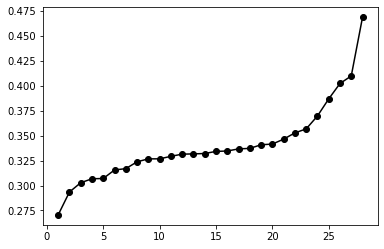

In [87]:
print(np.quantile(res.tolist(), [0,0.25,0.5,0.75,1]))
plt.plot(range(1, len(res)+1), sorted(res.tolist()), '-ok')

In [88]:
# df of DMSO vs treatment for each condition
d = pd.DataFrame(data=r.values(), index=r.keys(), columns=['ERCC pseudo-counts','var'])
d['Experiments'] = d.index
d

,ERCC pseudo-counts,var,Experiments
MV411-DMSO_1h,0.326152,0.012500,MV411-DMSO_1h
MV411-MS2_1h,0.334460,0.024322,MV411-MS2_1h
MV411-JQ1_1h,0.340617,0.027275,MV411-JQ1_1h
MV411-MYCi361_1h,0.328086,0.035988,MV411-MYCi361_1h
MV411-THZ1_1h,0.318405,0.013523,MV411-THZ1_1h
MV411-JQ1_MS2_1h,0.332300,0.014062,MV411-JQ1_MS2_1h
MV411-JQ1_THZ1_1h,0.403898,0.047729,MV411-JQ1_THZ1_1h


ERCC scaling factors (measures ERCC counts)
* treatment vs DMSO should be different
* &uarr; ERCC factor = &darr; transcripts
* protein level in treatment < DMSO: more ERCC transcripts in treatment than DMSO (less RNA transcripts)
* scaling factors: treatment > DMSO - ERCC counts/scaling factors in treatment should be higher
* scaling factor of control conditions should be similar

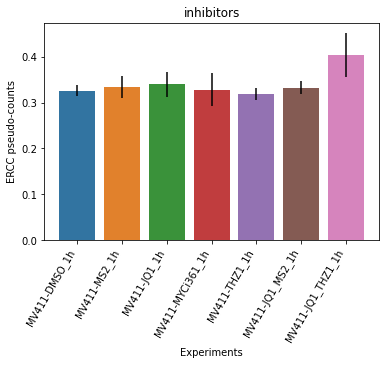

Saved to ../results/slamseq_inhibitors_v2/plots/inhibitors_v2_scaling_fact_with_conf.pdf


In [89]:
version = project.replace("_", " ").split(" ")[-1]
createDir(res_dir+"/plots/")

# barplot of DMSO vs inhibitor for each condition
sns.barplot(x="Experiments", y="ERCC pseudo-counts", data=d, ci=None, )
plt.errorbar(x=range(0,len(d)), y=d['ERCC pseudo-counts'],
             yerr=d['var'], fmt='none', ecolor="black")
plt.xticks(rotation=60, ha='right')
plt.title(project.replace("_", " ").split(" v")[0])

plt.savefig(res_dir+"plots/"+project+"_scaling_fact_with_conf.pdf", bbox_inches="tight")
plt.show()
print("Saved to "+res_dir+"plots/"+project+"_scaling_fact_with_conf.pdf")

__save average ERCC scaling factors__

In [90]:
d

,ERCC pseudo-counts,var,Experiments
MV411-DMSO_1h,0.326152,0.012500,MV411-DMSO_1h
MV411-MS2_1h,0.334460,0.024322,MV411-MS2_1h
MV411-JQ1_1h,0.340617,0.027275,MV411-JQ1_1h
MV411-MYCi361_1h,0.328086,0.035988,MV411-MYCi361_1h
MV411-THZ1_1h,0.318405,0.013523,MV411-THZ1_1h
MV411-JQ1_MS2_1h,0.332300,0.014062,MV411-JQ1_MS2_1h
MV411-JQ1_THZ1_1h,0.403898,0.047729,MV411-JQ1_THZ1_1h


In [91]:
# save avg ERCC pseudocounts
res_dir = "../results/slamseq_"+project+"/"
d.to_csv(res_dir+project+"_scaling_factors_avg.csv", header=True, index=True)

### save data to bucket

In [92]:
project

'inhibitors_v2'

In [93]:
! gsutil -m cp ../../data/slamseq_$project/res/filter/* gs://amlproject/RNA/slamseq/$project/res/filter/ 
! gsutil -m cp ../../data/slamseq_$project/res/snp/* gs://amlproject/RNA/slamseq/$project/res/snp/ 
! gsutil -m cp ../../data/slamseq_$project/res/count/* gs://amlproject/RNA/slamseq/$project/res/count/

Copying file://../../data/slamseq_inhibitors_v2/res/filter/ERCC_mr590-MV411-DMSO_1h-r1_filtered.bam.bed [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/filter/ERCC_mr595-MV411-MS2_1h-r2_filtered.bam.bed [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/filter/ERCC_mr594-MV411-MS2_1h-r1_filtered.bam.bed [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/filter/ERCC_mr592-MV411-DMSO_1h-r3_filtered.bam.bed [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/filter/ERCC_mr590-MV411-DMSO_1h-r1_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/filter/ERCC_mr596-MV411-MS2_1h-r3_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/filter/ERCC_mr593-MV411-DMSO_1h-r4_filtered.bam [Content-Type=application/oct

Copying file://../../data/slamseq_inhibitors_v2/res/filter/mr608-MV411-THZ1_1h-r3_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/filter/mr608-MV411-THZ1_1h-r3_filtered.bam.bai [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/filter/mr608-MV411-THZ1_1h-r3_filtered.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/filter/mr609-MV411-THZ1_1h-r4_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/filter/mr609-MV411-THZ1_1h-r4_filtered.bam.bai [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/filter/mr609-MV411-THZ1_1h-r4_filtered.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/filter/mr610-MV411-JQ1_MS2_1h-r1_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../da

Copying file://../../data/slamseq_inhibitors_v2/res/snp/mr610-MV411-JQ1_MS2_1h-r1_snp.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/snp/mr610-MV411-JQ1_MS2_1h-r1_snp.vcf [Content-Type=text/vcard]...
Copying file://../../data/slamseq_inhibitors_v2/res/snp/mr611-MV411-JQ1_MS2_1h-r2_snp.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/snp/mr611-MV411-JQ1_MS2_1h-r2_snp.vcf [Content-Type=text/vcard]...
Copying file://../../data/slamseq_inhibitors_v2/res/snp/mr612-MV411-JQ1_MS2_1h-r3_snp.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/snp/mr612-MV411-JQ1_MS2_1h-r3_snp.vcf [Content-Type=text/vcard]...
Copying file://../../data/slamseq_inhibitors_v2/res/snp/mr613-MV411-JQ1_MS2_1h-r4_snp.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/snp/mr613-MV411-JQ1_MS2_1h-r4_snp.vcf [Content-Type=text/vc

Copying file://../../data/slamseq_inhibitors_v2/res/count/mr600-MV411-JQ1_1h-r3_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/slamseq_inhibitors_v2/res/count/mr601-MV411-JQ1_1h-r4_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/count/mr601-MV411-JQ1_1h-r4_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/count/mr601-MV411-JQ1_1h-r4_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/count/mr601-MV411-JQ1_1h-r4_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/slamseq_inhibitors_v2/res/count/mr602-MV411-MYCi361_1h-r1_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/count/mr602-MV411-MYCi361_1h-r1_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../d

Copying file://../../data/slamseq_inhibitors_v2/res/count/mr615-MV411-JQ1_THZ1_1h-r2_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/count/mr615-MV411-JQ1_THZ1_1h-r2_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/count/mr615-MV411-JQ1_THZ1_1h-r2_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/slamseq_inhibitors_v2/res/count/mr616-MV411-JQ1_THZ1_1h-r3_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/count/mr616-MV411-JQ1_THZ1_1h-r3_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/count/mr616-MV411-JQ1_THZ1_1h-r3_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_inhibitors_v2/res/count/mr616-MV411-JQ1_THZ1_1h-r3_tcount.tsv [Content-Type=text/tab-separa

# SLAM-seq
All SLAM-seq assays were performed at 60-70% confluency for adherent cells or
60% of the maximum cell density counted on a hemocytometer for suspension cells. 5-7h
prior to each assay, growth medium was aspirated and replaced. Unless stated otherwise,
cells were pre-treated with indicated small molecule inhibitors or 100µM IAA for 30 min
to pre-establish full target inhibition or degradation. Newly synthesized RNA was labeled
for indicated time spans (45 min or 60 min) at a final concentration of 100µM 4-
thiouridine (4sU, Carbosynth). Adherent cells were harvested by direct snap-freezing of
plates on dry ice. Suspension cells were spun down and immediately snap-frozen. RNA
extraction was performed using the RNeasy Plus Mini Kit (Qiagen). 

Total RNA was subjected to alkylation by iodoacetamide (Sigma, 10mM) for 15 min and RNA was repurified by ethanol precipitation. 500ng alkylated RNA were used as input for generating
3’-end mRNA sequencing libraries using a commercially available kit (QuantSeq 3′
mRNA-Seq Library Prep Kit FWD for Illumina and PCR Add-on Kit for Illumina,
Lexogen). Deep sequencing was performed using HiSeq1500 and HiSeq2500 platforms
(Illumina).

## make count files

In [94]:
project = project
res_folder = "res"
location = "../../data/slamseq_"+project+"/"+res_folder+"/"+"count/"
print(location)

../../data/slamseq_inhibitors_v2/res/count/


In [95]:
# remove genes that have very low counts
mincount_toremove=5

# remove genes that have a variance of 0 across all samples (these we really want to remove)
# genes that have values of 0,1,2 everywhere
minvar_toremove=0

In [96]:
%%time

# all genes (not just protein coding)
readcounts, tccounts = rna.readFromSlamdunk(loc=location, 
                                            minvar_toremove=minvar_toremove, 
                                            mincount_toremove=mincount_toremove,
                                            verbose=False)

found 28 files:dict_keys(['mr590-MV411-DMSO_1h-r1_tcount', 'mr591-MV411-DMSO_1h-r2_tcount', 'mr592-MV411-DMSO_1h-r3_tcount', 'mr593-MV411-DMSO_1h-r4_tcount', 'mr594-MV411-MS2_1h-r1_tcount', 'mr595-MV411-MS2_1h-r2_tcount', 'mr596-MV411-MS2_1h-r3_tcount', 'mr597-MV411-MS2_1h-r4_tcount', 'mr598-MV411-JQ1_1h-r1_tcount', 'mr599-MV411-JQ1_1h-r2_tcount', 'mr600-MV411-JQ1_1h-r3_tcount', 'mr601-MV411-JQ1_1h-r4_tcount', 'mr602-MV411-MYCi361_1h-r1_tcount', 'mr603-MV411-MYCi361_1h-r2_tcount', 'mr604-MV411-MYCi361_1h-r3_tcount', 'mr605-MV411-MYCi361_1h-r4_tcount', 'mr606-MV411-THZ1_1h-r1_tcount', 'mr607-MV411-THZ1_1h-r2_tcount', 'mr608-MV411-THZ1_1h-r3_tcount', 'mr609-MV411-THZ1_1h-r4_tcount', 'mr610-MV411-JQ1_MS2_1h-r1_tcount', 'mr611-MV411-JQ1_MS2_1h-r2_tcount', 'mr612-MV411-JQ1_MS2_1h-r3_tcount', 'mr613-MV411-JQ1_MS2_1h-r4_tcount', 'mr614-MV411-JQ1_THZ1_1h-r1_tcount', 'mr615-MV411-JQ1_THZ1_1h-r2_tcount', 'mr616-MV411-JQ1_THZ1_1h-r3_tcount', 'mr617-MV411-JQ1_THZ1_1h-r4_tcount'])
mr590-MV411-DMSO_

check duplicate gene rows

In [97]:
def dedup_df_genes(df):
    ''' sum rows with the same gene index and remove duplicate '''
    if df.shape[0] != len(df.index.drop_duplicates()):
        print("Duplicate gene rows!")
        print("{} rows | {} unique genes".format(df.shape[0], len(df.index.drop_duplicates())))
        print("Summing of duplicate gene rows.")
        
    # sum duplicate rows, same row order
    duplicate_genes = df.index[df.index.duplicated()].tolist()
    df = df.groupby(df.index).sum().loc[df.index.drop_duplicates()]
    if df.shape[0] != len(df.index.drop_duplicates()):
        raise ValueError(
            "Cannot collapse duplicate gene rows."
        )
    
    return df, duplicate_genes

In [98]:
readcounts, duplicate_genes = dedup_df_genes(readcounts)
tccounts, duplicate_genes = dedup_df_genes(tccounts)

if readcounts.shape != tccounts.shape:
    raise ValueError("readcounts and tccounts not the same dimensions: {} | {}".format(readcounts.shape, tccounts.shape))

Duplicate gene rows!
16190 rows | 16154 unique genes
Summing of duplicate gene rows.
Duplicate gene rows!
16190 rows | 16154 unique genes
Summing of duplicate gene rows.


## make density plot

In [99]:
res_dir = "../results/slamseq_{}/".format(project)
print(res_dir)
createDir(res_dir)

../results/slamseq_inhibitors_v2/


In [100]:
# sort cols
col = tccounts.columns.tolist()
col.sort()
tccounts = tccounts[col]

In [101]:
# sort cols
col = readcounts.columns.tolist()
col.sort()
readcounts = readcounts[col]

In [102]:
print(readcounts.shape)
readcounts.iloc[:2]

(16154, 28)


,mr590-MV411-DMSO_1h-r1_tcount,mr591-MV411-DMSO_1h-r2_tcount,mr592-MV411-DMSO_1h-r3_tcount,mr593-MV411-DMSO_1h-r4_tcount,mr594-MV411-MS2_1h-r1_tcount,mr595-MV411-MS2_1h-r2_tcount,mr596-MV411-MS2_1h-r3_tcount,mr597-MV411-MS2_1h-r4_tcount,mr598-MV411-JQ1_1h-r1_tcount,mr599-MV411-JQ1_1h-r2_tcount,...,mr608-MV411-THZ1_1h-r3_tcount,mr609-MV411-THZ1_1h-r4_tcount,mr610-MV411-JQ1_MS2_1h-r1_tcount,mr611-MV411-JQ1_MS2_1h-r2_tcount,mr612-MV411-JQ1_MS2_1h-r3_tcount,mr613-MV411-JQ1_MS2_1h-r4_tcount,mr614-MV411-JQ1_THZ1_1h-r1_tcount,mr615-MV411-JQ1_THZ1_1h-r2_tcount,mr616-MV411-JQ1_THZ1_1h-r3_tcount,mr617-MV411-JQ1_THZ1_1h-r4_tcount
A1BG,0,1,0,1,3,0,2,3,6,1,...,2,0,0,2,0,0,8,0,0,0
NAT1,64,120,99,102,93,63,90,114,136,136,...,82,96,155,75,131,176,67,124,111,143


read counts that are t $\rightarrow$ c converted (actively transcribed)
* most at 0 = most are not transcribed
* a lot at 1 or everything at 0 is weird

15676


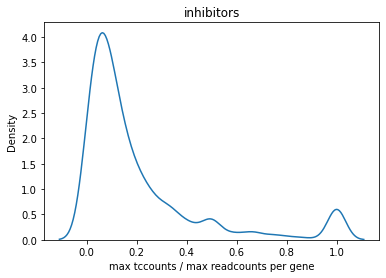

In [103]:
# what is the average of highly transcribed genes?
# tccounts/readcounts where sum of readcounts in all samples > 30 
a = tccounts[readcounts.sum(1)>30] / readcounts[readcounts.sum(1)>30]
a = a.fillna(0)
a = a.max(1).tolist() # max val per gene
a.sort()
print(len(a))
sns.kdeplot(a)
plt.xlabel("max tccounts / max readcounts per gene")
plt.title(project.replace("_", " ").split(" v")[0])

plt.savefig(res_dir+'plots/'+project+'_tccounts_readcounts_density.pdf', dpi=300, bbox_inches="tight")
plt.show()

In [104]:
# median or average across replicates t -> c converted
np.median(a)

0.1127782029925112

In [105]:
# Save counts to csv
counts_file_prefix = project+'_'+str(minvar_toremove)+'_'+str(mincount_toremove)

readcounts.to_csv(res_dir+counts_file_prefix+"_readcounts.csv",index=True, index_label="GENE")
print("Saved readcounts to: {}".format(res_dir+counts_file_prefix+"_readcounts.csv"))

tccounts.to_csv(res_dir+counts_file_prefix+"_tccounts.csv",index=True, index_label="GENE")
print("Saved tccounts to: {}".format(res_dir+counts_file_prefix+"_tccounts.csv"))

Saved readcounts to: ../results/slamseq_inhibitors_v2/inhibitors_v2_0_5_readcounts.csv
Saved tccounts to: ../results/slamseq_inhibitors_v2/inhibitors_v2_0_5_tccounts.csv


## make more dfs (mead, median, etc.)

In [106]:
readcounts.iloc[:1]

,mr590-MV411-DMSO_1h-r1_tcount,mr591-MV411-DMSO_1h-r2_tcount,mr592-MV411-DMSO_1h-r3_tcount,mr593-MV411-DMSO_1h-r4_tcount,mr594-MV411-MS2_1h-r1_tcount,mr595-MV411-MS2_1h-r2_tcount,mr596-MV411-MS2_1h-r3_tcount,mr597-MV411-MS2_1h-r4_tcount,mr598-MV411-JQ1_1h-r1_tcount,mr599-MV411-JQ1_1h-r2_tcount,...,mr608-MV411-THZ1_1h-r3_tcount,mr609-MV411-THZ1_1h-r4_tcount,mr610-MV411-JQ1_MS2_1h-r1_tcount,mr611-MV411-JQ1_MS2_1h-r2_tcount,mr612-MV411-JQ1_MS2_1h-r3_tcount,mr613-MV411-JQ1_MS2_1h-r4_tcount,mr614-MV411-JQ1_THZ1_1h-r1_tcount,mr615-MV411-JQ1_THZ1_1h-r2_tcount,mr616-MV411-JQ1_THZ1_1h-r3_tcount,mr617-MV411-JQ1_THZ1_1h-r4_tcount
A1BG,0,1,0,1,3,0,2,3,6,1,...,2,0,0,2,0,0,8,0,0,0


In [110]:
print("Genes with highest read counts per sample.")
for column in readcounts:
    print(column.split("-", 1)[1].split("-r",)[0] +": "+ str(readcounts[column].idxmax()) 
          +" ("+str(readcounts[column].max())+")")

Genes with highest read counts per sample.
MV411-DMSO_1h: RPL13AP5 (122109)
MV411-DMSO_1h: RPL13AP5 (99181)
MV411-DMSO_1h: RPL13AP5 (112916)
MV411-DMSO_1h: RPL13AP5 (126912)
MV411-MS2_1h: RPL13AP5 (108377)
MV411-MS2_1h: ACTG1 (83724)
MV411-MS2_1h: RPL13AP5 (120095)
MV411-MS2_1h: ACTG1 (117213)
MV411-JQ1_1h: ACTG1 (139535)
MV411-JQ1_1h: ACTG1 (113961)
MV411-JQ1_1h: RPL13AP5 (113605)
MV411-JQ1_1h: ACTG1 (101814)
MV411-MYCi361_1h: RPL13AP5 (111081)
MV411-MYCi361_1h: RPL13AP5 (63783)
MV411-MYCi361_1h: RPL13AP5 (119202)
MV411-MYCi361_1h: RPL13AP5 (110373)
MV411-THZ1_1h: RPL13AP5 (122538)
MV411-THZ1_1h: RPL13AP5 (129914)
MV411-THZ1_1h: RPL13AP5 (153616)
MV411-THZ1_1h: RPL13AP5 (118738)
MV411-JQ1_MS2_1h: ACTG1 (138403)
MV411-JQ1_MS2_1h: ACTG1 (108085)
MV411-JQ1_MS2_1h: ACTG1 (176357)
MV411-JQ1_MS2_1h: ACTG1 (148386)
MV411-JQ1_THZ1_1h: RPL13AP5 (141021)
MV411-JQ1_THZ1_1h: RPL13AP5 (157982)
MV411-JQ1_THZ1_1h: RPL13AP5 (134973)
MV411-JQ1_THZ1_1h: RPL13AP5 (145827)


In [111]:
print(set([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns]))
print(tccounts.columns[0].split('-', 1)[-1].rpartition("-")[0])
list(dict.fromkeys([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns]))

{'MV411-JQ1_THZ1_1h', 'MV411-JQ1_1h', 'MV411-MS2_1h', 'MV411-JQ1_MS2_1h', 'MV411-DMSO_1h', 'MV411-MYCi361_1h', 'MV411-THZ1_1h'}
MV411-DMSO_1h


['MV411-DMSO_1h',
 'MV411-MS2_1h',
 'MV411-JQ1_1h',
 'MV411-MYCi361_1h',
 'MV411-THZ1_1h',
 'MV411-JQ1_MS2_1h',
 'MV411-JQ1_THZ1_1h']

In [112]:
# get mean counts per condition
mtccounts = pd.DataFrame()
mreadcounts = pd.DataFrame()
# conditions maintaing column order
for i in list(dict.fromkeys([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns])):
    print(i)
    mtccounts[i] = tccounts[[v for v in tccounts.columns if i in v]].mean(1)
    mreadcounts[i] = readcounts[[v for v in readcounts.columns if i in v]].mean(1)

# save mean counts files
mtccounts.to_csv(res_dir+counts_file_prefix+"_mean_tccounts.csv", index=True, index_label="GENE")
mreadcounts.to_csv(res_dir+counts_file_prefix+"_mean_readcounts.csv", index=True, index_label="GENE")

MV411-DMSO_1h
MV411-MS2_1h
MV411-JQ1_1h
MV411-MYCi361_1h
MV411-THZ1_1h
MV411-JQ1_MS2_1h
MV411-JQ1_THZ1_1h


In [113]:
# get median counts per condition
mtccounts = pd.DataFrame()
mreadcounts = pd.DataFrame()
# conditions maintaing column order
for i in list(dict.fromkeys([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns])):
    print(i)
    mtccounts[i] = tccounts[[v for v in tccounts.columns if i in v]].median(1)
    mreadcounts[i] = readcounts[[v for v in readcounts.columns if i in v]].median(1)

# save median counts files
mtccounts.to_csv(res_dir+counts_file_prefix+"_median_tccounts.csv", index=True, index_label="GENE")
mreadcounts.to_csv(res_dir+counts_file_prefix+"_median_readcounts.csv", index=True, index_label="GENE")

MV411-DMSO_1h
MV411-MS2_1h
MV411-JQ1_1h
MV411-MYCi361_1h
MV411-THZ1_1h
MV411-JQ1_MS2_1h
MV411-JQ1_THZ1_1h


In [114]:
(tccounts/readcounts).fillna(0).iloc[:2]

,mr590-MV411-DMSO_1h-r1_tcount,mr591-MV411-DMSO_1h-r2_tcount,mr592-MV411-DMSO_1h-r3_tcount,mr593-MV411-DMSO_1h-r4_tcount,mr594-MV411-MS2_1h-r1_tcount,mr595-MV411-MS2_1h-r2_tcount,mr596-MV411-MS2_1h-r3_tcount,mr597-MV411-MS2_1h-r4_tcount,mr598-MV411-JQ1_1h-r1_tcount,mr599-MV411-JQ1_1h-r2_tcount,...,mr608-MV411-THZ1_1h-r3_tcount,mr609-MV411-THZ1_1h-r4_tcount,mr610-MV411-JQ1_MS2_1h-r1_tcount,mr611-MV411-JQ1_MS2_1h-r2_tcount,mr612-MV411-JQ1_MS2_1h-r3_tcount,mr613-MV411-JQ1_MS2_1h-r4_tcount,mr614-MV411-JQ1_THZ1_1h-r1_tcount,mr615-MV411-JQ1_THZ1_1h-r2_tcount,mr616-MV411-JQ1_THZ1_1h-r3_tcount,mr617-MV411-JQ1_THZ1_1h-r4_tcount
A1BG,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NAT1,0.0625,0.108333,0.111111,0.235294,0.150538,0.0,0.211111,0.175439,0.198529,0.213235,...,0.231707,0.28125,0.180645,0.146667,0.167939,0.170455,0.104478,0.145161,0.144144,0.230769


In [115]:
# Save tccounts/readcounts file
(tccounts/readcounts).fillna(0).to_csv(res_dir+counts_file_prefix+"_tccounts_per_readcounts.csv")
print("Saved tccounts/readcounts to: {}".format(res_dir+counts_file_prefix+"_tccounts_per_readcounts.csv"))

Saved tccounts/readcounts to: ../results/slamseq_inhibitors_v2/inhibitors_v2_0_5_tccounts_per_readcounts.csv


## look at similarity across replicates

In [116]:
# conditions
[i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns]

['MV411-DMSO_1h',
 'MV411-DMSO_1h',
 'MV411-DMSO_1h',
 'MV411-DMSO_1h',
 'MV411-MS2_1h',
 'MV411-MS2_1h',
 'MV411-MS2_1h',
 'MV411-MS2_1h',
 'MV411-JQ1_1h',
 'MV411-JQ1_1h',
 'MV411-JQ1_1h',
 'MV411-JQ1_1h',
 'MV411-MYCi361_1h',
 'MV411-MYCi361_1h',
 'MV411-MYCi361_1h',
 'MV411-MYCi361_1h',
 'MV411-THZ1_1h',
 'MV411-THZ1_1h',
 'MV411-THZ1_1h',
 'MV411-THZ1_1h',
 'MV411-JQ1_MS2_1h',
 'MV411-JQ1_MS2_1h',
 'MV411-JQ1_MS2_1h',
 'MV411-JQ1_MS2_1h',
 'MV411-JQ1_THZ1_1h',
 'MV411-JQ1_THZ1_1h',
 'MV411-JQ1_THZ1_1h',
 'MV411-JQ1_THZ1_1h']

Replicate similarity plot saved to: ../results/slamseq_inhibitors_v2/plots/inhibitors_v2_similarity_replicates_sorted_tccounts.pdf


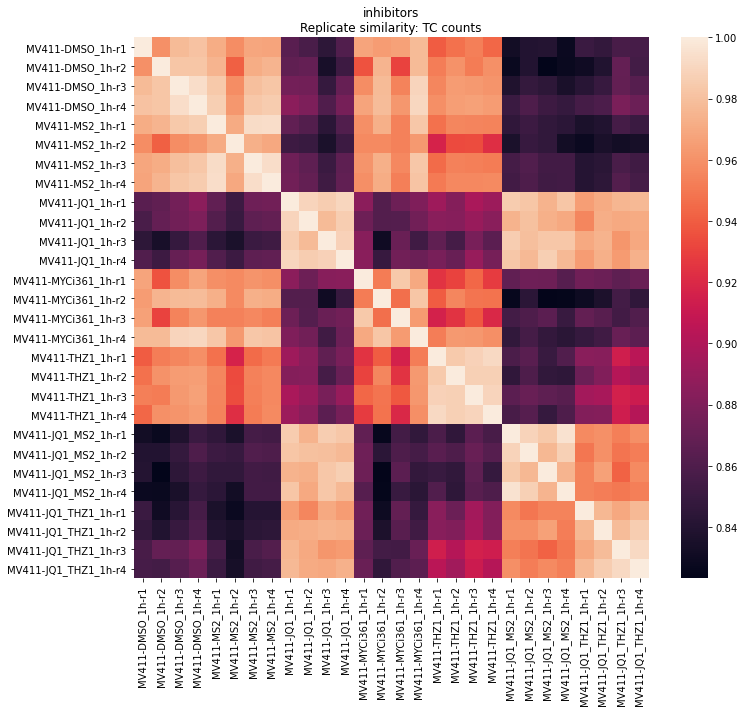

In [117]:
%matplotlib inline
import matplotlib.font_manager

font_settings = {
    "family" : "sans-serif",
    "size" : 10
}
plt.rc("font", **font_settings)

# tccounts
fig, ax = plt.subplots(figsize=(11,10))
sns.heatmap(tccounts.corr(),
            # condition w/ rep label
            xticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in tccounts.columns],
            yticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in tccounts.columns],
            ax=ax, cmap="rocket")#, vmin=0.9, vmax=1)
plt.title(project.replace("_", " ").split(" v")[0]+"\n"+"Replicate similarity: TC counts")
plt.tight_layout()

plt.savefig(res_dir+'plots/'+project+'_similarity_replicates_sorted_tccounts.pdf', dpi=300)

print("Replicate similarity plot saved to: {}".format(res_dir+'plots/'+project+
                                                      '_similarity_replicates_sorted_tccounts.pdf'))

all very similar (see scale)

Replicate similarity plot saved to: ../results/slamseq_inhibitors_v2/plots/inhibitors_v2_similarity_replicates_sorted_readcounts.pdf


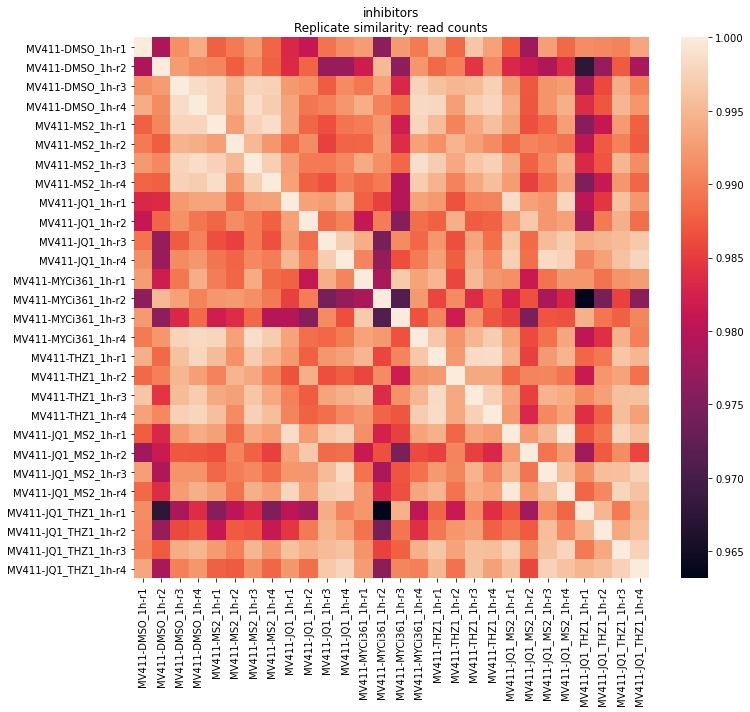

In [119]:
%matplotlib inline

# readcounts
fig, ax = plt.subplots(figsize=(11,10))
sns.heatmap(readcounts.corr(), 
            # condition w/ rep label
            xticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in tccounts.columns],
            yticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in tccounts.columns],
            ax=ax) #, vmin=0.985, vmax=1)
plt.title(project.replace("_", " ").split(" v")[0]+"\n"+"Replicate similarity: read counts")
plt.tight_layout()

plt.savefig(res_dir+'plots/'+project+'_similarity_replicates_sorted_readcounts.pdf', dpi=300)

print("Replicate similarity plot saved to: {}".format(res_dir+'plots/'+project+
                                                      '_similarity_replicates_sorted_readcounts.pdf'))

# DESeq Analysis

In [120]:
res_dir = "../results/slamseq_{}/".format(project)
print(res_dir)

../results/slamseq_inhibitors_v2/


In [121]:
# make genes col
readcounts["genes"] = readcounts.index
readcounts = readcounts.reset_index(drop=True)

tccounts["genes"] = tccounts.index
tccounts = tccounts.reset_index(drop=True)

__include all replicates__

__ERCC normalization__
* MS2 - no
* JQ1 - no
* MYCi361 - no
* THZ1 - no
* JQ1_MS2 - no
* JQ1_THZ1 - yes

In [129]:
drop_samples = []

# col info
cols = tccounts.columns[:-1]
experiments = [x.rsplit("-", 2)[0].split("-", 1)[-1] for x in cols]
conds = [x.split("-", 1)[1].rsplit("-", 1)[0] for x in cols]
time = [x.split("_")[-1] for x in conds]
treatment = [x.split("-")[-1].rsplit("_", 1)[0] for x in conds]
rep = [x.split("_")[-2].split("-")[-1] for x in cols]
drop = [True if any(sample in x for sample in drop_samples) else False for x in cols]

# experimental design
exp_design = pd.DataFrame(list(zip(cols, experiments, conds, time, treatment, rep, drop)), 
                          columns=["col", "experiment", "cond", "time", "treatment", "rep", "drop"])

exp_design

,col,experiment,cond,time,treatment,rep,drop
0,mr590-MV411-DMSO_1h-r1_tcount,MV411,MV411-DMSO_1h,1h,DMSO,r1,False
1,mr591-MV411-DMSO_1h-r2_tcount,MV411,MV411-DMSO_1h,1h,DMSO,r2,False
2,mr592-MV411-DMSO_1h-r3_tcount,MV411,MV411-DMSO_1h,1h,DMSO,r3,False
3,mr593-MV411-DMSO_1h-r4_tcount,MV411,MV411-DMSO_1h,1h,DMSO,r4,False
4,mr594-MV411-MS2_1h-r1_tcount,MV411,MV411-MS2_1h,1h,MS2,r1,False
5,mr595-MV411-MS2_1h-r2_tcount,MV411,MV411-MS2_1h,1h,MS2,r2,False
6,mr596-MV411-MS2_1h-r3_tcount,MV411,MV411-MS2_1h,1h,MS2,r3,False
7,mr597-MV411-MS2_1h-r4_tcount,MV411,MV411-MS2_1h,1h,MS2,r4,False
8,mr598-MV411-JQ1_1h-r1_tcount,MV411,MV411-JQ1_1h,1h,JQ1,r1,False
9,mr599-MV411-JQ1_1h-r2_tcount,MV411,MV411-JQ1_1h,1h,JQ1,r2,False


In [130]:
# save experimental design / metaData
exp_design.to_csv(res_dir+project+"_metaData.csv", index=False)
print("Save exp design/meta data to: "+res_dir+project+"_metaData.csv")

Save exp design/meta data to: ../results/slamseq_inhibitors_v2/inhibitors_v2_metaData.csv


## MV411 MS2 1h

### make design matrix

In [149]:
# MV411 MS2 inhibitor 1h
version = "v1"
var_name = "experiment"
var = "MV411"
var1 = "DMSO"
var2 = "MS2"
drop_rep = exp_design.loc[(exp_design[var_name] == var) & (exp_design["drop"] == True), "col"]

In [150]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

be careful that var_cols are only the samples being used for DESeq comparison!

In [151]:
# get just var data
# remove dropped reps
var1_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var1) and
             (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

var2_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var2) and 
            (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

var_cols = [sum(x) for x in zip(var1_cols, var2_cols)]

In [152]:
# all columns
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=[var1, var2], 
                      data=np.array([var1_cols, var2_cols], dtype=bool).T)

In [153]:
design

,DMSO,MS2
mr590.MV411.DMSO_1h.r1_tcount,True,False
mr591.MV411.DMSO_1h.r2_tcount,True,False
mr592.MV411.DMSO_1h.r3_tcount,True,False
mr593.MV411.DMSO_1h.r4_tcount,True,False
mr594.MV411.MS2_1h.r1_tcount,False,True
mr595.MV411.MS2_1h.r2_tcount,False,True
mr596.MV411.MS2_1h.r3_tcount,False,True
mr597.MV411.MS2_1h.r4_tcount,False,True
mr598.MV411.JQ1_1h.r1_tcount,False,False
mr599.MV411.JQ1_1h.r2_tcount,False,False


In [154]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [155]:
scaling="ERCCsamplewise"

__make DESeq object__

In [156]:
# tccounts DESeq gene object
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [157]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate and modify size factors__

In [158]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [159]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
res

0
ERCC_mr590-MV411-DMSO_1h-r1_filtered.bam    0.341648
ERCC_mr591-MV411-DMSO_1h-r2_filtered.bam    0.329341
ERCC_mr592-MV411-DMSO_1h-r3_filtered.bam    0.306805
ERCC_mr593-MV411-DMSO_1h-r4_filtered.bam    0.326813
ERCC_mr594-MV411-MS2_1h-r1_filtered.bam     0.293509
ERCC_mr595-MV411-MS2_1h-r2_filtered.bam     0.340927
ERCC_mr596-MV411-MS2_1h-r3_filtered.bam     0.346558
ERCC_mr597-MV411-MS2_1h-r4_filtered.bam     0.356847
Name: 1, dtype: float64

__modify size factors__
<br> VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [160]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [162]:
res[[i for i in res.index if '-'+str(var2) in i]].values

array([0.29350932, 0.3409273 , 0.34655803, 0.35684702])

In [163]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

__run it__

In [164]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.36 s, sys: 1.42 s, total: 8.78 s
Wall time: 6.38 s


In [165]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.22 s, sys: 1.4 s, total: 8.61 s
Wall time: 5.78 s


In [171]:
# MV411_MS2 1h tccounts ERCC
resGene_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A1BG,A1BG
1,11.278741,-0.148718,0.571009,0.260448,0.794518,NaN,NAT1,NAT1
2,19.380031,0.219618,0.388743,-0.564945,0.572111,NaN,AAMP,AAMP
3,23.376832,0.585985,0.327588,-1.788786,0.073649,NaN,AARS1,AARS1
4,6.735608,-0.780640,0.614815,1.269714,0.204187,NaN,ABAT,ABAT


In [173]:
# MV411_MS2 1h readcounts ERCC
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,1.147888,1.929197,1.682445,-1.146663,0.251521,NaN,A1BG,A1BG
1,90.855402,-0.107673,0.215839,0.498857,0.617880,0.999799,NAT1,NAT1
2,586.097983,-0.009824,0.121581,0.080801,0.935600,0.999799,AAMP,AAMP
3,754.528833,-0.095555,0.124452,0.767809,0.442601,0.999799,AARS1,AARS1
4,224.375051,-0.193613,0.152372,1.270660,0.203850,0.999799,ABAT,ABAT


__save DESeq results__

In [166]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [167]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'inhibitors_v2_MV411_DMSO_MS2_ERCCsamplewise_0_5_deseq_tccounts.csv'

In [168]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v2_MV411_DMSO_MS2_ERCCsamplewise_0_5_deseq_tccounts.csv


In [169]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v2_MV411_DMSO_MS2_ERCCsamplewise_0_5_deseq_readcounts.csv


### Unscaled

In [174]:
scaling = None

__make DESeq object__

In [175]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [176]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate size factors__

In [177]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

__run it__

In [178]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.42 s, sys: 1.12 s, total: 7.53 s
Wall time: 5.22 s


In [179]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.55 s, sys: 1.19 s, total: 7.74 s
Wall time: 5.37 s


In [180]:
# MV411_MS2 1h tccounts unscaled
resGene_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A1BG,A1BG
1,11.411210,-0.112885,0.577114,0.195603,0.844921,NaN,NAT1,NAT1
2,19.438824,0.236230,0.371229,-0.636347,0.524550,NaN,AAMP,AAMP
3,23.696280,0.615711,0.316885,-1.943013,0.052015,NaN,AARS1,AARS1
4,6.767263,-0.760593,0.598589,1.270643,0.203856,NaN,ABAT,ABAT


In [181]:
# MV411_MS2 1h readcounts unscaled
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,1.152078,1.949897,1.600378,-1.218397,0.223073,NaN,A1BG,A1BG
1,91.851721,-0.074586,0.209547,0.355937,0.721888,0.999635,NAT1,NAT1
2,591.926268,0.019644,0.100086,-0.196275,0.844395,0.999635,AAMP,AAMP
3,761.998616,-0.066296,0.109061,0.607874,0.543271,0.999635,AARS1,AARS1
4,226.081374,-0.166893,0.125873,1.325890,0.184876,0.999635,ABAT,ABAT


__save DESeq results__

In [182]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [184]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'inhibitors_v2_MV411_DMSO_MS2_0_5_deseq_tccounts.csv'

In [185]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v2_MV411_DMSO_MS2_0_5_deseq_tccounts.csv


In [186]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v2_MV411_DMSO_MS2_0_5_deseq_readcounts.csv


## MV411 JQ1 1h

### make design matrix

In [189]:
# MV411 JQ1 inhibitor 1h
version = "v1"
var_name = "experiment"
var = "MV411"
var1 = "DMSO"
var2 = "JQ1"
drop_rep = exp_design.loc[(exp_design[var_name] == var) & (exp_design["drop"] == True), "col"]

In [190]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

be careful that var_cols are only the samples being used for DESeq comparison!

In [191]:
# get just var data
# remove dropped reps
var1_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var1) and
             (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

var2_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var2) and 
            (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

var_cols = [sum(x) for x in zip(var1_cols, var2_cols)]

In [192]:
# all columns
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=[var1, var2], 
                      data=np.array([var1_cols, var2_cols], dtype=bool).T)

In [193]:
design

,DMSO,JQ1
mr590.MV411.DMSO_1h.r1_tcount,True,False
mr591.MV411.DMSO_1h.r2_tcount,True,False
mr592.MV411.DMSO_1h.r3_tcount,True,False
mr593.MV411.DMSO_1h.r4_tcount,True,False
mr594.MV411.MS2_1h.r1_tcount,False,False
mr595.MV411.MS2_1h.r2_tcount,False,False
mr596.MV411.MS2_1h.r3_tcount,False,False
mr597.MV411.MS2_1h.r4_tcount,False,False
mr598.MV411.JQ1_1h.r1_tcount,False,True
mr599.MV411.JQ1_1h.r2_tcount,False,True


In [195]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [196]:
scaling="ERCCsamplewise"

__make DESeq object__

In [197]:
# tccounts DESeq gene object
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [198]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate & modify size factors__

In [199]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [200]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
res

0
ERCC_mr590-MV411-DMSO_1h-r1_filtered.bam    0.341648
ERCC_mr591-MV411-DMSO_1h-r2_filtered.bam    0.329341
ERCC_mr592-MV411-DMSO_1h-r3_filtered.bam    0.306805
ERCC_mr593-MV411-DMSO_1h-r4_filtered.bam    0.326813
ERCC_mr598-MV411-JQ1_1h-r1_filtered.bam     0.331761
ERCC_mr599-MV411-JQ1_1h-r2_filtered.bam     0.326792
ERCC_mr600-MV411-JQ1_1h-r3_filtered.bam     0.386950
ERCC_mr601-MV411-JQ1_1h-r4_filtered.bam     0.316964
Name: 1, dtype: float64

__modify size factors__
<br> VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [201]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [202]:
res[[i for i in res.index if '-'+str(var2) in i]].values

array([0.33176145, 0.32679183, 0.38694976, 0.31696432])

In [203]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

__run it__

In [204]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.81 s, sys: 1.08 s, total: 7.89 s
Wall time: 5.62 s


In [205]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.8 s, sys: 1.11 s, total: 7.91 s
Wall time: 5.69 s


In [208]:
# MV411_JQ1 1h tccounts ERCC
resGene_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A1BG,A1BG
1,16.012768,1.087887,0.433848,-2.507533,0.012158,0.061639,NAT1,NAT1
2,16.843718,0.281413,0.384802,-0.731318,0.464585,0.688919,AAMP,AAMP
3,13.024040,-0.554660,0.449015,1.235283,0.216725,0.448141,AARS1,AARS1
4,9.717166,0.746722,0.505614,-1.476863,0.139712,0.335966,ABAT,ABAT


In [209]:
# MV411_JQ1 1h readcounts ERCC
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,1.423173,2.326387,1.578626,-1.473678,0.140568,NaN,A1BG,A1BG
1,104.290909,0.338331,0.216299,-1.564182,0.117775,0.447756,NAT1,NAT1
2,585.169422,0.054996,0.140307,-0.391973,0.695078,0.922618,AAMP,AAMP
3,750.079370,-0.037670,0.121871,0.309096,0.757248,0.945331,AARS1,AARS1
4,238.945124,0.065586,0.150230,-0.436569,0.662424,0.908213,ABAT,ABAT


__save DESeq results__

In [210]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [211]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'inhibitors_v2_MV411_DMSO_JQ1_ERCCsamplewise_0_5_deseq_tccounts.csv'

In [212]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v2_MV411_DMSO_JQ1_ERCCsamplewise_0_5_deseq_tccounts.csv


In [213]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v2_MV411_DMSO_JQ1_ERCCsamplewise_0_5_deseq_readcounts.csv


### Unscaled

In [214]:
scaling = None

__make DESeq object__

In [215]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [216]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate size factors__

In [217]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

__run it__

In [218]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.21 s, sys: 1.01 s, total: 7.22 s
Wall time: 5.19 s


In [219]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.04 s, sys: 1.11 s, total: 8.15 s
Wall time: 5.76 s


In [220]:
# MV411_JQ1 1h tccounts unscaled
resGene_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A1BG,A1BG
1,16.355392,1.134170,0.424570,-2.671338,0.007555,0.039449,NAT1,NAT1
2,17.315885,0.343377,0.382734,-0.897170,0.369628,0.596686,AAMP,AAMP
3,13.183596,-0.506053,0.442058,1.144768,0.252305,0.472794,AARS1,AARS1
4,9.919322,0.794265,0.497071,-1.597891,0.110067,0.278191,ABAT,ABAT


In [221]:
# MV411_JQ1 1h readcounts unscaled
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,1.420167,2.341675,1.551999,-1.508812,0.131347,NaN,A1BG,A1BG
1,106.387622,0.391566,0.205745,-1.903158,0.057020,0.265832,NAT1,NAT1
2,596.948045,0.111266,0.129907,-0.856502,0.391720,0.728893,AAMP,AAMP
3,766.617785,0.025227,0.122119,-0.206572,0.836344,0.951064,AARS1,AARS1
4,243.224390,0.118852,0.124638,-0.953581,0.340296,0.688540,ABAT,ABAT


__save DESeq results__

In [222]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [223]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'inhibitors_v2_MV411_DMSO_JQ1_0_5_deseq_tccounts.csv'

In [224]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v2_MV411_DMSO_JQ1_0_5_deseq_tccounts.csv


In [225]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v2_MV411_DMSO_JQ1_0_5_deseq_readcounts.csv


## MV411 MYCi361 1h

### make design matrix

In [227]:
# MV411 MYCi361 inhibitor 1h
version = "v1"
var_name = "experiment"
var = "MV411"
var1 = "DMSO"
var2 = "MYCi361"
drop_rep = exp_design.loc[(exp_design[var_name] == var) & (exp_design["drop"] == True), "col"]

In [228]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

be careful that var_cols are only the samples being used for DESeq comparison!

In [229]:
# get just var data
# remove dropped reps
var1_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var1) and
             (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

var2_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var2) and 
            (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

var_cols = [sum(x) for x in zip(var1_cols, var2_cols)]

In [230]:
# all columns
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=[var1, var2], 
                      data=np.array([var1_cols, var2_cols], dtype=bool).T)

In [231]:
design

,DMSO,MYCi361
mr590.MV411.DMSO_1h.r1_tcount,True,False
mr591.MV411.DMSO_1h.r2_tcount,True,False
mr592.MV411.DMSO_1h.r3_tcount,True,False
mr593.MV411.DMSO_1h.r4_tcount,True,False
mr594.MV411.MS2_1h.r1_tcount,False,False
mr595.MV411.MS2_1h.r2_tcount,False,False
mr596.MV411.MS2_1h.r3_tcount,False,False
mr597.MV411.MS2_1h.r4_tcount,False,False
mr598.MV411.JQ1_1h.r1_tcount,False,False
mr599.MV411.JQ1_1h.r2_tcount,False,False


In [232]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [233]:
scaling="ERCCsamplewise"

__make DESeq object__

In [234]:
# tccounts DESeq gene object
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [235]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate & modify size factors__

In [236]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [237]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
res

0
ERCC_mr590-MV411-DMSO_1h-r1_filtered.bam       0.341648
ERCC_mr591-MV411-DMSO_1h-r2_filtered.bam       0.329341
ERCC_mr592-MV411-DMSO_1h-r3_filtered.bam       0.306805
ERCC_mr593-MV411-DMSO_1h-r4_filtered.bam       0.326813
ERCC_mr602-MV411-MYCi361_1h-r1_filtered.bam    0.369813
ERCC_mr603-MV411-MYCi361_1h-r2_filtered.bam    0.334681
ERCC_mr604-MV411-MYCi361_1h-r3_filtered.bam    0.337304
ERCC_mr605-MV411-MYCi361_1h-r4_filtered.bam    0.270546
Name: 1, dtype: float64

__modify size factors__
<br> treatment size factor * adjusted treatment res (treatment res per sample / average DMSO res)

In [238]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [239]:
res[[i for i in res.index if '-'+str(var2) in i]].values

array([0.36981291, 0.33468096, 0.3373044 , 0.27054618])

In [240]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

__run it__

In [241]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.46 s, sys: 1.33 s, total: 7.79 s
Wall time: 5.18 s


In [242]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.14 s, sys: 1.2 s, total: 8.34 s
Wall time: 5.66 s


In [243]:
# MV411_MYCi361 1h tccounts ERCC
resGene_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A1BG,A1BG
1,11.364008,0.122771,0.548818,-0.223702,0.822989,0.995380,NAT1,NAT1
2,20.419774,0.609135,0.395090,-1.541763,0.123131,0.995380,AAMP,AAMP
3,16.433890,-0.000542,0.430949,0.001258,0.998996,0.999646,AARS1,AARS1
4,7.662240,0.006442,0.627995,-0.010259,0.991815,0.999109,ABAT,ABAT


In [244]:
# MV411_MYCi361 1h readcounts ERCC
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.338187,-0.374661,2.815385,0.133076,0.894133,0.999342,A1BG,A1BG
1,76.332710,-0.339530,0.281944,1.204246,0.228495,0.999342,NAT1,NAT1
2,580.397493,0.242652,0.170277,-1.425040,0.154146,0.999342,AAMP,AAMP
3,724.526141,0.079566,0.168190,-0.473076,0.636159,0.999342,AARS1,AARS1
4,218.686060,0.025266,0.163593,-0.154446,0.877258,0.999342,ABAT,ABAT


__save DESeq results__

In [245]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [246]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'inhibitors_v2_MV411_DMSO_MYCi361_ERCCsamplewise_0_5_deseq_tccounts.csv'

In [247]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v2_MV411_DMSO_MYCi361_ERCCsamplewise_0_5_deseq_tccounts.csv


In [248]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v2_MV411_DMSO_MYCi361_ERCCsamplewise_0_5_deseq_readcounts.csv


### Unscaled

In [249]:
scaling = None

__make DESeq object__

In [250]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [251]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate size factors__

In [252]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

__run it__

In [253]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.2 s, sys: 1.03 s, total: 7.23 s
Wall time: 5.08 s


In [254]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.8 s, sys: 1.26 s, total: 8.06 s
Wall time: 5.35 s


In [255]:
# MV411_MYCi361 1h tccounts unscaled
resGene_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A1BG,A1BG
1,11.139024,0.069253,0.524979,-0.131917,0.895050,NaN,NAT1,NAT1
2,20.402543,0.595437,0.379312,-1.569782,0.116466,NaN,AAMP,AAMP
3,16.464883,-0.008392,0.416799,0.020135,0.983936,NaN,AARS1,AARS1
4,7.628665,-0.015023,0.611296,0.024575,0.980394,NaN,ABAT,ABAT


In [256]:
# MV411_MYCi361 1h readcounts unscaled
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.353851,-0.375675,2.655547,0.141468,0.887500,NaN,A1BG,A1BG
1,75.432054,-0.370880,0.249294,1.487721,0.136824,0.990933,NAT1,NAT1
2,579.437598,0.238504,0.151507,-1.574217,0.115437,0.974605,AAMP,AAMP
3,725.049027,0.081247,0.160884,-0.505005,0.613556,0.998654,AARS1,AARS1
4,218.888414,0.025147,0.145837,-0.172434,0.863097,0.998654,ABAT,ABAT


__save DESeq results__

In [257]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [258]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'inhibitors_v2_MV411_DMSO_MYCi361_0_5_deseq_tccounts.csv'

In [259]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v2_MV411_DMSO_MYCi361_0_5_deseq_tccounts.csv


In [260]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v2_MV411_DMSO_MYCi361_0_5_deseq_readcounts.csv


## MV411 THZ1 1h

### make design matrix

In [330]:
# MV411 THZ1 inhibitor 1h
version = "v1"
var_name = "experiment"
var = "MV411"
var1 = "DMSO"
var2 = "THZ1"
drop_rep = exp_design.loc[(exp_design[var_name] == var) & (exp_design["drop"] == True), "col"]

In [331]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

be careful that var_cols are only the samples being used for DESeq comparison!

In [332]:
# get just var data
# remove dropped reps
var1_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var1) and
             (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

var2_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var2) and 
            (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

var_cols = [sum(x) for x in zip(var1_cols, var2_cols)]

In [333]:
# all columns
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=[var1, var2], 
                      data=np.array([var1_cols, var2_cols], dtype=bool).T)

In [334]:
design

,DMSO,THZ1
mr590.MV411.DMSO_1h.r1_tcount,True,False
mr591.MV411.DMSO_1h.r2_tcount,True,False
mr592.MV411.DMSO_1h.r3_tcount,True,False
mr593.MV411.DMSO_1h.r4_tcount,True,False
mr594.MV411.MS2_1h.r1_tcount,False,False
mr595.MV411.MS2_1h.r2_tcount,False,False
mr596.MV411.MS2_1h.r3_tcount,False,False
mr597.MV411.MS2_1h.r4_tcount,False,False
mr598.MV411.JQ1_1h.r1_tcount,False,False
mr599.MV411.JQ1_1h.r2_tcount,False,False


In [335]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [267]:
scaling="ERCCsamplewise"

__make DESeq object__

In [268]:
# tccounts DESeq gene object
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [269]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate & modify size factors__

In [270]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [271]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
res

0
ERCC_mr590-MV411-DMSO_1h-r1_filtered.bam    0.341648
ERCC_mr591-MV411-DMSO_1h-r2_filtered.bam    0.329341
ERCC_mr592-MV411-DMSO_1h-r3_filtered.bam    0.306805
ERCC_mr593-MV411-DMSO_1h-r4_filtered.bam    0.326813
ERCC_mr606-MV411-THZ1_1h-r1_filtered.bam    0.332162
ERCC_mr607-MV411-THZ1_1h-r2_filtered.bam    0.307091
ERCC_mr608-MV411-THZ1_1h-r3_filtered.bam    0.302844
ERCC_mr609-MV411-THZ1_1h-r4_filtered.bam    0.331523
Name: 1, dtype: float64

__modify size factors__
<br> treatment size factor * adjusted treatment res (treatment res per sample / average DMSO res)

In [272]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [273]:
res[[i for i in res.index if '-'+str(var2) in i]].values

array([0.33216161, 0.30709091, 0.30284441, 0.33152302])

In [274]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

__run it__

In [275]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.14 s, sys: 948 ms, total: 7.09 s
Wall time: 5.09 s


In [276]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.53 s, sys: 1.05 s, total: 7.58 s
Wall time: 5.32 s


In [277]:
# MV411_THZ1 1h tccounts ERCC
resGene_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A1BG,A1BG
1,16.341669,0.796559,0.456243,-1.745911,0.080826,0.341939,NAT1,NAT1
2,22.638732,0.650350,0.362258,-1.795266,0.072611,0.323883,AAMP,AAMP
3,19.577324,0.222348,0.352068,-0.631550,0.527681,0.809884,AARS1,AARS1
4,7.579216,-0.263466,0.654244,0.402702,0.687167,0.886090,ABAT,ABAT


In [278]:
# MV411_THZ1 1h readcounts ERCC
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.487363,-0.111977,2.392620,0.046801,0.962672,NaN,A1BG,A1BG
1,89.520006,-0.346670,0.212734,1.629593,0.103188,0.596566,NAT1,NAT1
2,666.491153,0.179213,0.123788,-1.447749,0.147687,0.657923,AAMP,AAMP
3,848.270932,0.068116,0.114740,-0.593656,0.552742,0.911350,AARS1,AARS1
4,248.985595,-0.063884,0.119042,0.536648,0.591511,0.919225,ABAT,ABAT


__save DESeq results__

In [279]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [280]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'inhibitors_v2_MV411_DMSO_THZ1_ERCCsamplewise_0_5_deseq_tccounts.csv'

In [281]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v2_MV411_DMSO_THZ1_ERCCsamplewise_0_5_deseq_tccounts.csv


In [282]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v2_MV411_DMSO_THZ1_ERCCsamplewise_0_5_deseq_readcounts.csv


### Unscaled

In [336]:
scaling = None

__make DESeq object__

In [337]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [338]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate size factors__

In [339]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

__run it__

In [340]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.33 s, sys: 1.18 s, total: 7.51 s
Wall time: 5.16 s


In [341]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.89 s, sys: 1.08 s, total: 7.98 s
Wall time: 5.66 s


In [342]:
# MV411_THZ1 1h tccounts unscaled
resGene_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A1BG,A1BG
1,16.232279,0.776478,0.463341,-1.675825,0.093773,0.376173,NAT1,NAT1
2,22.123248,0.600572,0.356349,-1.685348,0.091921,0.373828,AAMP,AAMP
3,19.235653,0.178562,0.349378,-0.511085,0.609291,0.852206,AARS1,AARS1
4,7.537041,-0.287342,0.658202,0.436555,0.662434,0.880280,ABAT,ABAT


In [343]:
# MV411_THZ1 1h readcounts unscaled
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.471109,-0.170525,2.390105,0.071346,0.943122,NaN,A1BG,A1BG
1,88.682583,-0.379690,0.217529,1.745469,0.080903,0.512022,NAT1,NAT1
2,658.247022,0.144779,0.126837,-1.141455,0.253681,0.757179,AAMP,AAMP
3,836.746182,0.029366,0.105584,-0.278128,0.780914,0.976086,AARS1,AARS1
4,245.837956,-0.101640,0.108256,0.938891,0.347787,0.820811,ABAT,ABAT


__save DESeq results__

In [344]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [345]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'inhibitors_v2_MV411_DMSO_THZ1_0_5_deseq_tccounts.csv'

In [346]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v2_MV411_DMSO_THZ1_0_5_deseq_tccounts.csv


In [347]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v2_MV411_DMSO_THZ1_0_5_deseq_readcounts.csv


## MV411 JQ1_MS2 1h

### make design matrix

In [297]:
# MV411 THZ1 inhibitor 1h
version = "v1"
var_name = "experiment"
var = "MV411"
var1 = "DMSO"
var2 = "JQ1_MS2"
drop_rep = exp_design.loc[(exp_design[var_name] == var) & (exp_design["drop"] == True), "col"]

In [298]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

be careful that var_cols are only the samples being used for DESeq comparison!

In [299]:
# get just var data
# remove dropped reps
var1_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var1) and
             (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

var2_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var2) and 
            (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

var_cols = [sum(x) for x in zip(var1_cols, var2_cols)]

# all columns
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=[var1, var2], 
                      data=np.array([var1_cols, var2_cols], dtype=bool).T)

In [300]:
design

,DMSO,JQ1_MS2
mr590.MV411.DMSO_1h.r1_tcount,True,False
mr591.MV411.DMSO_1h.r2_tcount,True,False
mr592.MV411.DMSO_1h.r3_tcount,True,False
mr593.MV411.DMSO_1h.r4_tcount,True,False
mr594.MV411.MS2_1h.r1_tcount,False,False
mr595.MV411.MS2_1h.r2_tcount,False,False
mr596.MV411.MS2_1h.r3_tcount,False,False
mr597.MV411.MS2_1h.r4_tcount,False,False
mr598.MV411.JQ1_1h.r1_tcount,False,False
mr599.MV411.JQ1_1h.r2_tcount,False,False


In [301]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [302]:
scaling="ERCCsamplewise"

__make DESeq object__

In [303]:
# tccounts DESeq gene object
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [304]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate & modify size factors__

In [305]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [306]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
res

0
ERCC_mr590-MV411-DMSO_1h-r1_filtered.bam       0.341648
ERCC_mr591-MV411-DMSO_1h-r2_filtered.bam       0.329341
ERCC_mr592-MV411-DMSO_1h-r3_filtered.bam       0.306805
ERCC_mr593-MV411-DMSO_1h-r4_filtered.bam       0.326813
ERCC_mr610-MV411-JQ1_MS2_1h-r1_filtered.bam    0.315682
ERCC_mr611-MV411-JQ1_MS2_1h-r2_filtered.bam    0.323851
ERCC_mr612-MV411-JQ1_MS2_1h-r3_filtered.bam    0.336793
ERCC_mr613-MV411-JQ1_MS2_1h-r4_filtered.bam    0.352872
Name: 1, dtype: float64

__modify size factors__
<br> treatment size factor * adjusted treatment res (treatment res per sample / average DMSO res)

In [307]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [308]:
res[[i for i in res.index if '-'+str(var2) in i]].values

array([0.31568212, 0.32385117, 0.33679293, 0.352872  ])

In [309]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

__run it__

In [310]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.52 s, sys: 912 ms, total: 7.44 s
Wall time: 5.47 s


In [311]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.47 s, sys: 972 ms, total: 7.44 s
Wall time: 5.21 s


In [312]:
# MV411_JQ1_MS2 1h tccounts ERCC
resGene_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A1BG,A1BG
1,17.005494,0.997743,0.421877,-2.365007,0.018030,0.073388,NAT1,NAT1
2,18.514801,0.285635,0.388265,-0.735672,0.461931,0.674098,AAMP,AAMP
3,18.263086,0.146687,0.365801,-0.401003,0.688418,0.838437,AARS1,AARS1
4,9.114300,0.371837,0.536210,-0.693454,0.488025,0.694274,ABAT,ABAT


In [313]:
# MV411_JQ1_MS2 1h readcounts ERCC
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.586216,-0.035220,2.319772,0.015183,0.987886,NaN,A1BG,A1BG
1,110.632372,0.238793,0.217530,-1.097748,0.272314,0.600980,NAT1,NAT1
2,629.776595,-0.015397,0.121981,0.126223,0.899556,0.968948,AAMP,AAMP
3,848.272130,0.031244,0.116140,-0.269020,0.787914,0.931638,AARS1,AARS1
4,252.939200,-0.062557,0.136425,0.458545,0.646561,0.870697,ABAT,ABAT


__save DESeq results__

In [314]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [315]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'inhibitors_v2_MV411_DMSO_JQ1_MS2_ERCCsamplewise_0_5_deseq_tccounts.csv'

In [316]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v2_MV411_DMSO_JQ1_MS2_ERCCsamplewise_0_5_deseq_tccounts.csv


In [317]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v2_MV411_DMSO_JQ1_MS2_ERCCsamplewise_0_5_deseq_readcounts.csv


### Unscaled

In [318]:
scaling = None

__make DESeq object__

In [319]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [320]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate size factors__

In [321]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

__run it__

In [322]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.18 s, sys: 1 s, total: 7.18 s
Wall time: 5.12 s


In [323]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.57 s, sys: 1.02 s, total: 7.59 s
Wall time: 5.33 s


In [324]:
# MV411_JQ1_MS2 1h tccounts unscaled
resGene_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A1BG,A1BG
1,17.249085,1.027387,0.420521,-2.443131,0.014560,0.063630,NAT1,NAT1
2,18.780456,0.319608,0.388688,-0.822275,0.410920,0.631437,AAMP,AAMP
3,18.460985,0.175935,0.362857,-0.484860,0.627776,0.802453,AARS1,AARS1
4,9.263419,0.408224,0.534194,-0.764186,0.444756,0.662197,ABAT,ABAT


In [325]:
# MV411_JQ1_MS2 1h readcounts unscaled
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.583942,-0.022111,2.317750,0.009540,0.992388,NaN,A1BG,A1BG
1,111.793876,0.266942,0.221932,-1.202812,0.229049,0.551979,NAT1,NAT1
2,635.634625,0.011804,0.122278,-0.096536,0.923094,0.977182,AAMP,AAMP
3,856.279326,0.058351,0.116565,-0.500590,0.616660,0.853497,AARS1,AARS1
4,255.204279,-0.035121,0.133727,0.262634,0.792833,0.932753,ABAT,ABAT


__save DESeq output__

In [326]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [327]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'inhibitors_v2_MV411_DMSO_JQ1_MS2_0_5_deseq_tccounts.csv'

In [328]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v2_MV411_DMSO_JQ1_MS2_0_5_deseq_tccounts.csv


In [329]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: inhibitors_v2_MV411_DMSO_JQ1_MS2_0_5_deseq_readcounts.csv


## MV411 JQ1_THZ1 1h

### make design matrix

In [348]:
# MV411 THZ1 inhibitor 1h
version = "v1"
var_name = "experiment"
var = "MV411"
var1 = "DMSO"
var2 = "JQ1_THZ1"
drop_rep = exp_design.loc[(exp_design[var_name] == var) & (exp_design["drop"] == True), "col"]

In [349]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

be careful that var_cols are only the samples being used for DESeq comparison!

In [350]:
# get just var data
# remove dropped reps
var1_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var1) and
             (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

var2_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var2) and 
            (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

var_cols = [sum(x) for x in zip(var1_cols, var2_cols)]

# all columns
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=[var1, var2], 
                      data=np.array([var1_cols, var2_cols], dtype=bool).T)

In [351]:
design

,DMSO,JQ1_THZ1
mr590.MV411.DMSO_1h.r1_tcount,True,False
mr591.MV411.DMSO_1h.r2_tcount,True,False
mr592.MV411.DMSO_1h.r3_tcount,True,False
mr593.MV411.DMSO_1h.r4_tcount,True,False
mr594.MV411.MS2_1h.r1_tcount,False,False
mr595.MV411.MS2_1h.r2_tcount,False,False
mr596.MV411.MS2_1h.r3_tcount,False,False
mr597.MV411.MS2_1h.r4_tcount,False,False
mr598.MV411.JQ1_1h.r1_tcount,False,False
mr599.MV411.JQ1_1h.r2_tcount,False,False


In [352]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [353]:
scaling="ERCCsamplewise"

__make DESeq object__

In [354]:
# tccounts DESeq gene object
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [355]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate & modify size factors__

In [356]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [357]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
res

0
ERCC_mr590-MV411-DMSO_1h-r1_filtered.bam        0.341648
ERCC_mr591-MV411-DMSO_1h-r2_filtered.bam        0.329341
ERCC_mr592-MV411-DMSO_1h-r3_filtered.bam        0.306805
ERCC_mr593-MV411-DMSO_1h-r4_filtered.bam        0.326813
ERCC_mr614-MV411-JQ1_THZ1_1h-r1_filtered.bam    0.468901
ERCC_mr615-MV411-JQ1_THZ1_1h-r2_filtered.bam    0.409994
ERCC_mr616-MV411-JQ1_THZ1_1h-r3_filtered.bam    0.334275
ERCC_mr617-MV411-JQ1_THZ1_1h-r4_filtered.bam    0.402424
Name: 1, dtype: float64